# Assignment 3
### Mariella Daghfal, Kaede Johnson, Shayan Khajehnouri, & Tahel Singer

In [ ]:
# For TA: 

#  ctrl+f C:/Users/HP/ to change filepaths where necessary

# xml set of polska files required (ctrl + f xml_file_location). xml set from zeng's github.

# requirements.txt on github repo: https://github.com/kaedejohnson/DH401-A1-RHYTHMGEN

# Cell under 'Comparisons' must be run to do distances with the polska corpus. It overwrites the corpus import from the fourth cell.

# some stuff (including the generative model) are in this file. other critically important stuff is in helpers.py on github repo.

# TO SKIP TO GENERATION: ctrl+f 'Generation' (look for markdown. first is random, then bigrams)
#                      bigrams is our model. it's set up to create and spit out all 500 in a weird format, after which you create bigrams_final.pkl in the next block.
# TO SKIP TO DISTANCE CALCULATIONS: ctrl+f 'Comparisons' (look for markdown) 
#                      need bigrams_final.pkl, randoms_final.pkl in lists_for_generation on github. ALSO NEED to import xml polskas. Goes quicker if you pull in levenshtein_costs. Fasttext is too large to be stored on Git; must retrain in code below.
#                      run next few cells to generate
#                      normalize and combine rhythm, lenvenshtein, form distances: ctrl+f: Normalize and Combine Distance Functions into one metric
#
# have FUN


In [ ]:
## Dependencies
from music21 import *
from music21 import note
from tqdm import *
import pandas as pd
import numpy as np
import collections
import pickle
import math
import os
# Many important functions in helpers.py.
# Sequestered them only to the make the Jupyter notebook readable.
from helpers import *

In [ ]:
# Setup environment
# # to be safe i personally created venv with anaconda terminal.
# conda create -n "digital_musicology" python=3.8
# conda activate digital_musicology
# conda install pip
 
# Setup music21
## for viewing score, download and install finale note pad at https://store.makemusic.com/Downloads/Default.aspx?id=538&_ga=2.3616692.58482559.1678537005-1850486829.1678537005 and then run:
# configure.run()

## I don't know if it's because I screwed up something during initial setup but this is what I had to do to get music showing:
# environment.set('musescoreDirectPNGPath', 'C:\\Program Files (x86)\\Finale NotePad 2012\\Finale NotePad.exe')

# Bach score from package
# s = corpus.parse('bach/bwv65.2.xml')

# Print music12 object to show it worked
# s.show('text')

# image version (ideally this is inline but i can't get that working; for me it pulls open finale note pad with the sheet music in a separate window)
# s.show()

In [ ]:
## Load scores into corpus
# Be sure to modify folder path below

# CHANGE FOLDER BELOW TO LOCATION OF XML FILES. Download xml folders from https://github.com/DCMLab/music-generation-challenge-2021/tree/main/data
xml_file_location = 'C:/Users/HP/anaconda3/envs/digital_musicology/xml/'

# Argument defaults to False as of 20230410
slangpolska_scores = import_slangpolskas(xml_file_location, keepScoresWithChords=True)

## Below is the investigation that led to scores with chords in the first 8 measures being removed above.
## Comment in here and relevant exclusion in helpers.py to see numbers
# Investigating presence of chords
#chord = 0
#total = 0
#s_w_chord = 0
#chords = []
#for i, score in enumerate(slangpolska_scores):
#    score_counted = 0
#    for i in slangpolska_scores[score].recurse().notes:
#        if i.measureNumber > 8:
#            break
#        try:
#            chords.append(i.pitchedCommonName)
#            chord += 1
#            total += 1
#            if score_counted == 0:
#                s_w_chord += 1
#                score_counted = 1
#        except:
#            total += 1
#print("Across the first 8 measures of all scores, " + str(chord) + " chords out of " + str(total) + " notes and chords.")
#print(str(s_w_chord) + " scores with chords in the first 8 measures")
#from collections import Counter
#Counter(chords)
# Less than 1% of all events in the first 8 measures are chords. Ignoring.


In [ ]:
## Investigating one score to get familiar with music21
## Comment in to see basic structure
#sample_score = slangpolska_scores['_1814_698087.xml']
#print('music21 object for imported score is called ' + str(type(sample_score)))
#print('sample score key is ' + str(sample_score.analyze('key')))
#print('The first time signature object is ' + sample_score.recurse().getElementsByClass(meter.TimeSignature)[0].ratioString)
#print('There is (are) ' + str(len(sample_score.recurse().getElementsByClass(meter.TimeSignature))) + ' time signature object(s)')
#print('Measure 6 does not have a time signature object: ' + str(sample_score.measure(6).timeSignature is None))
#print('Recall the sample score is in time ' + sample_score.recurse().getElementsByClass(meter.TimeSignature)[0].ratioString)
#curr_measure = 0
#for i in sample_score.recurse().notes:
#    if i.measureNumber != curr_measure:
#        curr_measure = i.measureNumber
#        print("Measure " + str(curr_measure))
#    print('Beat: ' + str(i.beat) + ', Duration: ' + str(i.duration.quarterLength) + ', Pitch: ' + str(i.name) + ', Accents: ' + str(i.articulations))
#print('Music21 object print:')
#sample_score.show('text')

In [ ]:
# Investigating accent share of notes - conclusion: precious few, can ignore for these assignments
from collections import Counter
total_note_count = 0
total_accents = 0
total_scores_w_accents = 0
articulations = []
for i, score in enumerate(slangpolska_scores):
    fresh_score = 1
    for note in slangpolska_scores[score].recurse().notesAndRests:
        total_note_count += 1
        if len(note.articulations) > 0:
            total_accents += len(note.articulations)
            articulations.append(note.articulations)
            if fresh_score == 1:
                total_scores_w_accents += 1
                fresh_score = 0
flat_articulations = [artic.name for sublist in articulations for artic in sublist]
accent_shares = collections.Counter(flat_articulations).most_common(10)
for i in range(len(accent_shares)):
    accent_shares[i] = (accent_shares[i][0], accent_shares[i][1] / total_note_count)
print("Shares of scores with accents")
print(total_scores_w_accents / len(slangpolska_scores.keys()))
print("Share of notes with certain accent type")
print(accent_shares)
print("Share of all notes with some type of accent")
overall_accent_share = 0
for item in accent_shares:
    overall_accent_share += item[1]
print(overall_accent_share)

In [ ]:
# Early Tokenization for onset distribution exploration - comment in to see onset distribution

# Tokenization for onsets - similar tokenziation occurs later in generative model
# Starting simple until we define rhythm. Tokens will simply be location of beat in measure (that is, first element in Beat: , Duration: , Pitch: printout sequence above)
# First, observe where beats can occur (also sneakily multiply beat timings by 12 because see output + explanation in next cell)
#import collections
#all_beats = []
#for score in slangpolska_scores:
#    if (slangpolska_scores[score].recurse().notes[-1].measureNumber >= 4): # and (slangpolska_scores[score].recurse().notes[0].beat == 1):
#        for note in slangpolska_scores[score].recurse().notesAndRests:
#            all_beats.append(float(note.beat) + (3 * (note.measureNumber-1)))
#note_placements = collections.Counter(all_beats).most_common(100)
#location = []
#frequency = []
#for i,tuple in enumerate(note_placements):
#    try:
#        if np.isnan(float((tuple[0]))) == False:
#            location.append(float((tuple[0])))
#            frequency.append(tuple[1])
#    except:
#        print(tuple[0])

# Quick look at onsets

#import pandas as pd
#import matplotlib.pyplot as plt
#max_frequency = max(frequency)
#onset_distribution = pd.DataFrame(list(zip(location, frequency)),
#               columns =['atomic_moment', 'frequency'])
#onset_distribution['frequency'] = onset_distribution['frequency'] / max_frequency
#onset_distribution = onset_distribution.sort_values(by='atomic_moment')
#onset_distribution = onset_distribution[onset_distribution['atomic_moment'] <= 12]
#plt.plot(onset_distribution['atomic_moment'], onset_distribution['frequency'], color='red', marker='o')
#plt.title('Onset Distribution', fontsize=14)
#plt.xlabel('Measure (tick indicates first beat)', fontsize=14)
#plt.xticks([1, 4, 7, 10], ['1','2','3','4'])
#plt.ylabel('Frequency', fontsize=14)
#plt.grid(True)
#plt.show()

In [ ]:
from matplotlib import pyplot as plt

# Tonal character

all_beats = []
for score in slangpolska_scores:
    for note in slangpolska_scores[score].recurse().notesAndRests:
        try:
            tmp = ''
            pitch = note.name
            if pitch == 'C#' or pitch == 'D-':
                tmp = 'C#'
            if pitch == 'D#' or pitch == 'E-':
                tmp = 'D#'
            if pitch == 'F' or pitch == 'E#':
                tmp = "F"
            if pitch == 'G#' or pitch == 'A-':
                tmp = "G#"
            if pitch == 'A#' or pitch == 'B-':
                tmp = "A#"
            if pitch == 'B':
                tmp = "B"
            if tmp != '':
                all_beats.append(tmp)
            else:
                all_beats.append(note.name)
        except:
            pass
note_pitches = collections.Counter(all_beats).most_common(100)

dist_dict = {}
for pitch in note_pitches:
    if pitch[0] != 'rest':
        dist_dict[pitch[0]] = pitch[1]

myKeys = list(dist_dict.keys())
myKeys.sort()
dist_dict = {i: dist_dict[i] for i in myKeys}

# Quick look at onsets

#import matplotlib.pyplot as plt
plt.bar(list(dist_dict.keys()), dist_dict.values(), color='g')
plt.show()
#plt.plot(onset_distribution['atomic_moment'], onset_distribution['frequency'], color='red', marker='o')
#plt.title('Onset Distribution', fontsize=14)
#plt.xlabel('Measure (tick indicates first beat)', fontsize=14)
#plt.xticks([1, 4, 7, 10], ['1','2','3','4'])
#plt.ylabel('Frequency', fontsize=14)
#plt.grid(True)
#plt.show()

In [ ]:
# Exploration stops here. 

Output notes for model development

In [ ]:
# Output notes for ML generative model - abandoned, saving for future use if neeeded
score_name = []
measure_number = []
beat = []
duration = []
pitch = []
chord = []
event_type = []
for i,score in enumerate(slangpolska_scores):
    curr_score = slangpolska_scores[score]
    for event in curr_score.recurse().notesAndRests:
        score_name.append(score)
        measure_number.append(event.measureNumber)
        beat.append(event.beat)
        duration.append(event.duration.quarterLength)
        try:
            pitch.append(event.name)
        except:
            pitch.append(None)
        try:
            chord.append(event.pitchClasses)
        except:
            chord.append(None)
        event_type.append(str(type(event)))
print(score_name)
dnotes = pd.DataFrame(list(zip(score_name, measure_number, beat, duration, pitch, chord, event_type)),
               columns =['Score Name','Measure','Onset','Duration','Pitch','Chord','Event'])
dnotes.to_pickle("./dnotes.pkl")

# Generation

In [ ]:
# Random generation - note to TAs: our random model generates one measure at a time, choosing randomly from the notes in the list called durations.
# Only notes that will not surpass the end of the third beat of the measure can be added at any given point

# Random
import random
def random_measure():
    durations = [3, 2, 1, 1/2, 1/4, 1/8]
    pitches = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    
    beat_limit = 3
    def select_notes(durations, pitches, beat_limit):
        # initialize the current sum and selected numbers list
        current_beat_sum = 0
        selected = []

        # randomly select durations until their sum equals beat_limit
        while current_beat_sum != beat_limit:
            # randomly select a duration from the durations array
            dur = random.choice(durations)
            if current_beat_sum + min(durations) > beat_limit:
                dur = beat_limit - current_beat_sum
            # if adding the selected duration would exceed the beats in measure, skip it
            elif current_beat_sum + dur > beat_limit:
                continue
            # add the selected duration to the current sum and then to selected list alongside a random pitch
            current_beat_sum += dur
            pit = random.choice(pitches)
            selected.append((dur, pit))
        return selected
    
    return select_notes(durations, pitches, beat_limit)

In [ ]:
# Create sets of 8 random measures
# FOR TAs: here we saved random.pkl as random_final.pkl once to calculate distances. No longer _final so we don't overwrite. 
random_set_list_fmt = []
for run in range(500):
    new_rand_tmp = []
    for measure in range(8):
        new_rand_tmp.append(random_measure())
    #print(new_rand_tmp)
    random_set_list_fmt.append([event for measure in new_rand_tmp for event in measure])

# Music21 doesn't like being saved as pkl and reloaded. Save lists instead.
with open('lists_for_generation/randoms.pkl', 'wb') as f: # randoms_final SEE COMMENT ABOVE
    pickle.dump(random_set_list_fmt, f)

In [76]:
# BIGRAMS
# MESSAGE TO TA: some of us have issues with this in VSCode. Others do not. If your IDE is giving you issues,
# you are advised to ctrl+f 'for run in range(25)' and change 25 to a lower number (this will produce a smaller amount 
# of generated rhythms before saving, allowing you to recover the file and proceed). Then proceed to 
# the next code block to pull in the generated file and, with the next few blocks, create the generated music21 score
# Try-except to catch error based on bigram that doesn't appear in corpus (explained further in paper). Basically, restarts
# the sequence if such a circumstance occurs.

from collections import Counter
from itertools import chain
import random

def get_note(_quarterLength, _beat, _pitch):
    return {
        "duration": _quarterLength,
        "beat": _beat,
        "pitch": _pitch
    }
def bigrams_start_notes():
    return bigrams_start_notes
    
def first_measure_note(): 
    return {
        "duration": "start_tag",
        "beat": -1,
        "pitch": "Z"
    }
    
def last_measure_note():
    return {
        "duration": "end_tag",
        "beat": -1,
        "pitch": "Z"
    }

def init_model():
     # a dictionary that holds the bigrams per key
    key_dict = {}
    for key in myKeys:
        key_dict[key] = {}
        key_dict[key]["general_bigrams"] = []
        key_dict[key]["end_start_bigrams"] = []
# append to our dict each key with an inialized array
    
    # bigrams for the durations and pitches
    durations = []
    # gather bigram statistics type:
    # iterate over all the corpus, measure by measure and fill the array of the notes
   # bigrams_notes = [] # a list of lists of tuples [[("2", "b")], [("1", "a")]] -> return Counter(chain(*self.tupel_word_dict))
   # bigrams_start_notes = []
    for piece in slangpolska_scores:
        sample_score = slangpolska_scores[piece]
        curr_measure = 0
        first_measure_note = {
            "duration": "start_tag",
            "beat": -1,
            "pitch": "Z"
        }
        last_measure_note = {
            "duration": "end_tag",
            "beat": -1,
            "pitch": "Z"
        }
    #    measure = []

        k = ''

        start_note = ''
        final_note = ''
        
        last_note = first_measure_note

        #for measure in sample_score.getElementByClass(stream.Part)[0].getElementByClass(stream.Measure):
        for measure in sample_score[stream.Measure]:
            # get the key
            if measure.flat.keySignature is not None:
                k = measure.flat.keySignature.name
                if k not in key_dict.keys():
                    key_dict[k] = {}
                    key_dict[k]["general_bigrams"] = []
                    key_dict[k]["end_start_bigrams"] = []
            if not k:
                print("for some reason we are screwed :D")
            index = 0
            for event in measure.notes:
                chord_found = 0
                try:
                    event.pitchedCommonName
                    chord_found = 1
                except:
                    pass
                if chord_found == 1:
                    break
                if index == 0:
                    start_note = get_note(event.quarterLength, event.beat, event.name)
                    if final_note: # if we are not in the first measure of the piece
                        key_dict[k]["end_start_bigrams"].append((final_note, start_note))
                        # append the start tag if we get the first note
                key_dict[k]["general_bigrams"].append((last_note, get_note(event.quarterLength, event.beat, event.name))) # TOdO recheck
                last_note = get_note(event.quarterLength, event.beat, event.name)
                index += 1
            # post notes loop
            final_note = last_note
            key_dict[k]["general_bigrams"].append((last_note, last_measure_note)) # adding the end token


    return key_dict

dictionnary = init_model()

def generate_measures(key_dict, key):
    # Generate a sequence within a squence of 8 measures, each measure created with a context of having a start and end note. Building the measure from start to end within this given random context
    measures = []


    """""""""""""""""""""""""""""""""""""""""""""""
    you can iterate through the key_dict. Each entry has two objects per key:
    * the bigrams (with start and end token) of all relevant measures and
    * the bigrams of each end note of the previous measure with the start note of the current measure 
    """""""""""""""""""""""""""""""""""""""""""""""

 #   example for getting all first notes of a specific key
    first_notes = [item[1] for item in key_dict[key]["general_bigrams"] if item[0]["duration"] == "start_tag"]

 #  example for getting the occurences of each key (amount of bigrams)
    key_dict_occurences = {}
    for key in key_dict:
        key_dict_occurences[key] = len(key_dict[key]["general_bigrams"])   


    """""""""""""""""""""""""""""""""""""""""""""""
    From here implement the algorithm :)
    I left the old algorithm for inspiration
    """""""""""""""""""""""""""""""""""""""""""""""

    #print(bigrams_start_notes[:10]) # kaede comment out
    #print(bigrams_notes[:10]) # kaede comment out
    # do the range till 6
    
    measure = []
    total_duration = 0
    bigrams_durations = [0.5, 0.25, 1.5, 1.0, 0.0, 2.0, 0.75, 0.125, 3.0, 0.375, Fraction(1, 6), 0.875, Fraction(1, 3), Fraction(1, 12)]

    bigrams_candidates_start_note = [item[1] for item in key_dict[key]["general_bigrams"] if item[0]["duration"] == "start_tag"]

    first_note = random.choice(bigrams_candidates_start_note)
    measure.append(first_note)
    total_duration = first_note["duration"]
        
    # add last note if possible
    possible_durations = list(filter(lambda x: x <= 3 - total_duration, bigrams_durations)) # kaede add bigrams_ to durations
    bigrams_candidates_end_note = [item[0] for item in key_dict[key]["general_bigrams"] if item[1]["duration"] == "end_tag"]
    # in case the first note is a full measure
    if (not bigrams_candidates_end_note):
        measure.append(last_measure_note())
        return measure
    last_note = random.choice(bigrams_candidates_end_note)
    measure.append(last_note)
    total_duration += last_note["duration"]

    while (total_duration < 3):
        previous_note = measure[-2] # last appended note
        duration_candidates = list(filter(lambda x: x <= 3 - total_duration, bigrams_durations)) # kaede add bigrams_ to durations
        if not duration_candidates: # in case the fraction messed up the summation
            break
        # get all possible relevant candidates based on the last note plus that are in duration candidates
        bigrams_candidates = [item[1] for item in key_dict[key]["general_bigrams"] if item[0] == previous_note and item[1]["duration"] in duration_candidates]
        bigrams_candidates = bigrams_candidates + [item[0] for item in key_dict[key]["general_bigrams"] if item[1] == last_note and item[0]["duration"] == 3 - total_duration] # get all gap fillers
        # random weighted pick
        next_note = random.choice(bigrams_candidates)
        total_duration += next_note["duration"]
        measure.insert(len(measure) - 1, next_note) # inserts it on the position before the last one

    # for m in measures: # kaede comment out
    #    print(m)
    
    return measure
   
notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
def transpose(measure, interval):
    new_measure = []
    for n in measure:
        note = n['pitch']
        ind = (notes.index(note) + interval)%len(notes)
        new_note = notes[ind]
        new_measure.append({'duration':n['duration'], 'beat':n['beat'], 'pitch':new_note})
    return new_measure
    
#function to generate measures that follows the structuring of an ABAB' Period with A composed of a and a', B composed of b and c and B' composed of b and c'
def generate_full_measures(key_dict, key): 
    measures = [] 
    a = generate_measures(key_dict, key)
    a_prime= transpose(a, 5) 
    b= generate_measures(key_dict, key)
    c= generate_measures(key_dict, key)  
    c_prime = transpose(c, 5)
    measures.extend([a, a_prime, b,c,a, a_prime, b, c_prime])
    return measures

keys = []
weights = []
for k in dictionnary.keys():
    if len(dictionnary[k]['general_bigrams']) != 0:
        keys.append(k)
        weights.append(len(dictionnary[k]['general_bigrams']))
weights = np.array(weights)
weights = weights / sum(weights)

from numpy.random import choice
generated = []
for i in range(500):
    key = choice(keys, 1, p = weights)
    gen = generate_full_measures(dictionnary, key[0])
    generated.append(gen)

NameError: name 'myKeys' is not defined

In [ ]:
# FOR TAs: here we saved bigrams.pkl as bigrams_final.pkl once to calculate distances. No longer _final so we don't overwrite. 
# TAS: also change your directory to where you saved bigrams_*_*.pkl in the previous block
import pickle
import glob, os
os.chdir("C:/Users/HP/DH401-A1-RHYTHMGEN/DH401-A1-RHYTHMGEN/")
files = []
for file in glob.glob("lists_for_generation/bigrams_prefinal.pkl"):
    files.append(file)
samples = []
for filename in files:
    with open(filename, 'rb') as f:
        x = pickle.load(f)
        samples.append(x)
bigram_set_list_fmt_tmp = [lst for list in samples for lst in list]
bigram_set_list_fmt_tmp = bigram_set_list_fmt_tmp[0:500]
bigram_set_list_fmt = []

for score in bigram_set_list_fmt_tmp:
    score_list = []
    for measure in score:
        for event in measure:
            tmp = -2
            if event["pitch"] == 'C':
                tmp = 0
            if event["pitch"] == 'C#' or event["pitch"] == 'D-':
                tmp = 1
            if event["pitch"] == 'D':
                tmp = 2
            if event["pitch"] == 'D#' or event["pitch"] == 'E-':
                tmp = 3
            if event["pitch"] == 'E':
                tmp = 4
            if event["pitch"] == 'F' or event["pitch"] == 'E#':
                tmp = 5
            if event["pitch"] == 'F#':
                tmp = 6
            if event["pitch"] == 'G':
                tmp = 7
            if event["pitch"] == 'G#' or event["pitch"] == 'A-':
                tmp = 8
            if event["pitch"] == 'A':
                tmp = 9
            if event["pitch"] == 'A#' or event["pitch"] == 'B-':
                tmp = 10
            if event["pitch"] == 'B':
                tmp = 11
            if tmp == -2:
                print(event["pitch"])
            score_list.append((event["duration"],tmp))
    bigram_set_list_fmt.append(score_list)

print(len(bigram_set_list_fmt))

with open('lists_for_generation/bigrams.pkl', 'wb') as f: #bigrams_final.pkl SEE COMMENT ABOVE
    pickle.dump(bigram_set_list_fmt, f)


Create music21 scores from lists in block below. See helpers.py for conversion function (adapted from tutorial files)

In [ ]:
# This block creates music21 scores out of the bigram-generated lists and randomly generated lists

with open('lists_for_generation/randoms_final.pkl', 'rb') as f:
    random_set_list_fmt = pickle.load(f)

generated_from_random = []
for i,generated_score in enumerate(random_set_list_fmt):
    score = score_from_sequence(random_set_list_fmt[i], time_sig='3/4')
    #score.show()
    generated_from_random.append(score)

with open('lists_for_generation/bigrams_final.pkl', 'rb') as f:
    bigram_set_list_fmt = pickle.load(f)

generated_from_bigrams = []
for i,generated_score in enumerate(bigram_set_list_fmt):
    score = score_from_sequence(bigram_set_list_fmt[i], time_sig='3/4')
    #score.show()
    generated_from_bigrams.append(score)

print("# of random scores:")
print(len(generated_from_random))
print("# of bigram scores:")
print(len(generated_from_bigrams))

In [ ]:
# Generated scores to xml -> be sure to push these to github when done 
for i, score in enumerate(generated_from_bigrams):
    tmp_xml = stream.Score(generated_from_bigrams[i])
    tmp_xml.write("xml", 'bigrams_final/bigrams_' + str(i) + '.xml')
for i, score in enumerate(generated_from_random):
    tmp_xml = stream.Score(generated_from_random[i])
    tmp_xml.write("xml", 'random_final/random_' + str(i) + '.xml')

# Comparisons

In [ ]:
# Pull in slangpolska (helpful to have command down here during testing)
xml_file_location = 'C:/Users/HP/anaconda3/envs/digital_musicology/xml/'
slangpolska_scores = import_slangpolskas(xml_file_location, keepScoresWithChords=False)

# Compare Corpuses (Form)

In [8]:
# Convert scores into measure strings necessary for form distance
generated_from_random_partitioned_measures = partition_measures_wrapper(generated_from_random, "rand")
generated_from_bigrams_partitioned_measures = partition_measures_wrapper(generated_from_bigrams, "bigr")
abandon1, slangpolska_scores_partitioned_measures, abandon2 = partition_measures_wrapper(slangpolska_scores, "orig")

# Calculate max length of measure in terms of notes (16 is baseline from slangpolska corpus)
tmp_max = 16
for i in generated_from_random_partitioned_measures:
    for measure_str in generated_from_random_partitioned_measures[i]:
        if (measure_str.count('|') + 1) > tmp_max:
            tmp_max = generated_from_random_partitioned_measures[i][j].count('|') + 1
for i in generated_from_bigrams_partitioned_measures:
    for measure_str in generated_from_bigrams_partitioned_measures[i]:
        if (measure_str.count('|') + 1) > tmp_max:
            tmp_max = generated_from_bigrams_partitioned_measures[i][j].count('|') + 1
max_measure_length = tmp_max

In [9]:
# Train embedder
train_measure_embedder(max_measure_length, xml_file_location)

  2%|▎         | 15/600 [00:00<00:08, 72.20it/s]

excluding 1b651a94a8f8680da3cef1e60705194d.xml. Only 4 measures.
excluding 32a7f688d6c7ffc643473e7067ab5945.xml. Only 1 measures.
excluding 60ae81952628613e03d563b0dae8bbc2.xml. Only 2 measures.
excluding 6a7d307d1f0712090e4043a6b4637efa.xml. Only 3 measures.
excluding 8c6965e3c831e8cb769e578423c12d1e.xml. Only 4 measures.
excluding a0e1af6a94ac4663c193e7d6d9818189.xml. Only 3 measures.


  6%|▌         | 37/600 [00:00<00:09, 57.43it/s]

excluding Ninas_slängpolska_20240b.xml. 2 meter(s), first is 3/4


 23%|██▎       | 137/600 [00:05<00:27, 17.05it/s]

excluding Poloness_ur_Andreas_Hööks_notbok_cae293.xml. 4 meter(s), first is 2/2


 23%|██▎       | 140/600 [00:05<00:28, 16.07it/s]

excluding Polonoise_92b598.xml. 2 meter(s), first is 3/4
excluding Polonoise_No_30_ur_Stakels_notsamling_90c44f.xml. Only 6 measures.


 36%|███▌      | 213/600 [00:09<00:07, 52.26it/s]

excluding Polonäs_efter_Gustaf_Weslien_2981d4.xml. Only 6 measures.


 48%|████▊     | 286/600 [00:10<00:05, 55.65it/s]

excluding Polonäs_i_Dm_efter_Daniel_Danielsson_ac3754.xml. 2 meter(s), first is 3/4


 55%|█████▍    | 327/600 [00:11<00:04, 64.23it/s]

excluding Polonäs_sexdregasamlingen_del_3_nr_1_d8c3dc.xml. 2 meter(s), first is 3/4


 64%|██████▍   | 384/600 [00:13<00:05, 40.28it/s]

excluding Polska_efter_Wesslén_bec4ac.xml. 2 meter(s), first is 3/4
excluding Polska_efter_Wesslén_ce0449.xml. 2 meter(s), first is 3/4
excluding Polska_efter_Wesslén_fc5278.xml. 2 meter(s), first is 3/4


 66%|██████▋   | 398/600 [00:14<00:04, 48.72it/s]

excluding Polska_från_Västergötland_4b64d8.xml. 3 meter(s), first is 3/4


 71%|███████   | 426/600 [00:14<00:03, 52.09it/s]

excluding Sydjämtsk_slängpolska_efter_JohnErik_Mattsson_2a0874.xml. 2 meter(s), first is 3/4


 80%|████████  | 481/600 [00:15<00:01, 66.80it/s]

excluding _Polonäs_sexdregasamlingen_del_1_nr_36_dfc2c9.xml. 2 meter(s), first is 3/4
excluding _Polonäs_sexdregasamlingen_del_1_nr_36_ed2b21.xml. 2 meter(s), first is 3/4


 94%|█████████▍| 565/600 [00:17<00:00, 57.56it/s]

excluding _Polska_efter_Gustav_Strutz_21bb05.xml. 5 meter(s), first is 3/4
excluding _Polska_efter_Gustav_Strutz_5b7324.xml. 5 meter(s), first is 3/4


 99%|█████████▊| 592/600 [00:17<00:00, 39.47it/s]

excluding _Polska_Kringellåt_efter_Snickar_Erik_985b63.xml. 3 meter(s), first is 4/4


100%|██████████| 600/600 [00:18<00:00, 33.26it/s]


Imported 576 scores into corpus. Excluded 23 due to inconsistent meter, polyphonic setup, less than 8 measures, or chord presence in the first 8 measures.
9262
16
3388


In [10]:
# Embed measures
import pickle 
import numpy as np

model = FastText.load('fasttext')
encoder_model = model.wv

def embed_measures(partitioned_measures, encoder_model):
    embedded_measures = {}
    for score in partitioned_measures:
        tmp_embedded_measure_set = []
        for measure in partitioned_measures[score]:
            measure_vec = encoder_model[measure.replace("|"," ")]
            tmp_embedded_measure_set.append(measure_vec)
        embedded_measures[score] = tmp_embedded_measure_set[0:8]
    return embedded_measures

slangpolska_scores_embedded_measures = embed_measures(slangpolska_scores_partitioned_measures, encoder_model)
generated_from_random_embedded_measures = embed_measures(generated_from_random_partitioned_measures, encoder_model)
generated_from_bigrams_embedded_measures = embed_measures(generated_from_bigrams_partitioned_measures, encoder_model)

with open('embedded_measures/orig.pkl', 'wb') as f:
    pickle.dump(slangpolska_scores_embedded_measures, f)
with open('embedded_measures/rand.pkl', 'wb') as f:
    pickle.dump(generated_from_random_embedded_measures, f)
with open('embedded_measures/bigr.pkl', 'wb') as f:
    pickle.dump(generated_from_bigrams_embedded_measures, f)

In [11]:
# Form distance comparisons, measure embeddings from FastText - see helpers.py for underlying functions

# Combinations:
# orig-orig
# orig-rand
# orig-bigr
# bigr-bigr
# bigr-rand
# rand-rand
print('Calculating orig-orig. Form distance task 1/6')
compare(slangpolska_scores, slangpolska_scores, 'orig', 'orig', 'form')
print('Calculating orig-rand. Form distance task 2/6')
compare(slangpolska_scores, generated_from_random, 'orig', 'rand', 'form')
print('Calculating orig-bigr. Form distance task 3/6')
compare(slangpolska_scores, generated_from_bigrams, 'orig', 'bigr', 'form')
print('Calculating bigr-bigr. Form distance task 4/6')
compare(generated_from_bigrams, generated_from_bigrams, 'bigr', 'bigr', 'form')
print('Calculating bigr-rand. Form distance task 5/6')
compare(generated_from_bigrams, generated_from_random, 'bigr', 'rand', 'form')
print('Calculating rand-rand. Form distance task 6/6')
compare(generated_from_random, generated_from_random, 'rand', 'rand', 'form')

Calculating orig-orig. Form distance task 1/6


100%|██████████| 512/512 [03:21<00:00,  2.54it/s]


Calculating orig-rand. Form distance task 2/6


100%|██████████| 512/512 [05:45<00:00,  1.48it/s]


Calculating orig-bigr. Form distance task 3/6


100%|██████████| 512/512 [05:54<00:00,  1.45it/s]


Calculating bigr-bigr. Form distance task 4/6


100%|██████████| 500/500 [03:15<00:00,  2.56it/s]


Calculating bigr-rand. Form distance task 5/6


100%|██████████| 500/500 [05:26<00:00,  1.53it/s]


Calculating rand-rand. Form distance task 6/6


100%|██████████| 500/500 [02:42<00:00,  3.07it/s]


# Compare Corpuses (Rhythm)

In [12]:
# This should be reinitialized if you want to run the rhythm distance fresh
full_chronotonic_sequence_holder = {}

In [13]:
# Chronotonic comparisons - see helpers.py for underlying functions
# As of 20230410, this block calculates the geographic distance between the first 8 bars
# of chronotonic rhythm sequences between each score in set a and each score in set b (sets a and b can be the same).
#
# Note compare() is the same distance function used for pitch; arguments specify rhythm in this case
# full_chronotonic_sequence_holder SHOULD BE REINITIALIZED IF ANYTHING ABOUT THE DISTANCE CALCULATION CHANGES

# Combinations:
# orig-orig
# orig-rand
# orig-bigr
# bigr-bigr
# bigr-rand
# rand-rand
print('Calculating orig-orig. Rhythm distance task 1/6')
full_chronotonic_sequence_holder = compare(slangpolska_scores, slangpolska_scores, 'orig', 'orig', 'rhythm', full_chronotonic_sequence_holder)
print('Calculating orig-rand. Rhythm distance task 2/6')
full_chronotonic_sequence_holder = compare(slangpolska_scores, generated_from_random, 'orig', 'rand', 'rhythm', full_chronotonic_sequence_holder)
print('Calculating orig-bigr. Rhythm distance task 3/6')
full_chronotonic_sequence_holder = compare(slangpolska_scores, generated_from_bigrams, 'orig', 'bigr', 'rhythm', full_chronotonic_sequence_holder)
print('Calculating bigr-bigr. Rhythm distance task 4/6')
full_chronotonic_sequence_holder = compare(generated_from_bigrams, generated_from_bigrams, 'bigr', 'bigr', 'rhythm', full_chronotonic_sequence_holder)
print('Calculating bigr-rand. Rhythm distance task 5/6')
full_chronotonic_sequence_holder = compare(generated_from_bigrams, generated_from_random, 'bigr', 'rand', 'rhythm', full_chronotonic_sequence_holder)
print('Calculating rand-rand. Rhythm distance task 6/6')
full_chronotonic_sequence_holder = compare(generated_from_random, generated_from_random, 'rand', 'rand', 'rhythm', full_chronotonic_sequence_holder)

    

Calculating orig-orig. Rhythm distance task 1/6


100%|██████████| 512/512 [18:49<00:00,  2.21s/it]


Calculating orig-rand. Rhythm distance task 2/6


100%|██████████| 512/512 [28:36<00:00,  3.35s/it]


Calculating orig-bigr. Rhythm distance task 3/6


100%|██████████| 512/512 [30:48<00:00,  3.61s/it]


Calculating bigr-bigr. Rhythm distance task 4/6


100%|██████████| 500/500 [13:32<00:00,  1.62s/it]


Calculating bigr-rand. Rhythm distance task 5/6


100%|██████████| 500/500 [24:22<00:00,  2.93s/it]


Calculating rand-rand. Rhythm distance task 6/6


100%|██████████| 500/500 [13:33<00:00,  1.63s/it]


# Compare Corpuses (Pitch Sequence)

In [14]:
# First, create distribution of Levenshtein distance operations in orig-orig 
# to re-weight insertions, deletions, and substitutions for ultimate pitch distance calculations
# adapted from https://pypi.org/project/python-Levenshtein/
import Levenshtein
import tqdm
from collections import Counter

# function to find edit operations involved in shortest edit distance between two strings
def editops_as_ascii(str1, str2):
    editops_indices = Levenshtein.editops(str1, str2)
    insertions = []
    deletions = []
    substitutions = []
    for operation in editops_indices:
        if operation[0] == 'insert':
            insertions.append((operation[0], str2[operation[2]]))
        if operation[0] == 'delete':
            deletions.append((operation[0], str1[operation[1]]))
        if operation[0] == 'replace':
            substitutions.append((operation[0], str1[operation[1]], str2[operation[2]]))
    return insertions, deletions, substitutions

# create distribution of all edit operations for all orig-orig pitch sequences
insertions_nonflat = []
deletions_nonflat = []
substitutions_nonflat = []
for score_i in tqdm.tqdm(slangpolska_scores.keys()):
    for score_j in list(slangpolska_scores):
        insertions, deletions, substitutions = editops_as_ascii(pitch_sequence(slangpolska_scores[score_i]), pitch_sequence(slangpolska_scores[score_j]))
        insertions_nonflat.append(insertions)
        deletions_nonflat.append(deletions)
        substitutions_nonflat.append(substitutions)
insertions_tot = [op for oplist in insertions_nonflat for op in oplist]
deletions_tot = [op for oplist in deletions_nonflat for op in oplist]
substitutions_tot = [op for oplist in substitutions_nonflat for op in oplist]

all_operations_tot = insertions_tot + deletions_tot + substitutions_tot
d = Counter(all_operations_tot)
distribution = [(i, d[i] / len(all_operations_tot)) for i in d]

100%|██████████| 512/512 [11:22<00:00,  1.33s/it]


In [15]:
# Ensure symmetric operations are equal cost
pitches = ["A","B","C","D","E","F","G","a","b","c","d","e","f","g"]
distribution_reweighted = []
for pitch_i in pitches:
    for pitch_j in pitches:
        if pitch_i != pitch_j:
            replace_symm_i_j = -1
            replace_i_j_tmp = -1
            replace_j_i_tmp = -1
            found = 0
            for operation in distribution:
                if operation[0][0] == 'replace' and operation[0][1] == pitch_i and operation[0][2] == pitch_j:
                    replace_i_j_tmp = operation[1]
                if operation[0][0] == 'replace' and operation[0][1] == pitch_j and operation[0][2] == pitch_i:
                    replace_i_j_tmp = operation[1]
                if replace_i_j_tmp != -1 and replace_j_i_tmp != -1:
                    replace_symm_i_j = (replace_i_j_tmp + replace_j_i_tmp) / 2
                    found = 1
                if found == 1:
                    break
            if replace_symm_i_j == -1 and replace_i_j_tmp != -1:
                replace_symm_i_j = replace_i_j_tmp
            if replace_symm_i_j == -1 and replace_j_i_tmp != -1:
                replace_symm_i_j = replace_j_i_tmp
            distribution_reweighted.append((('replace', pitch_i, pitch_j), replace_symm_i_j))
            distribution_reweighted.append((('replace', pitch_j, pitch_i), replace_symm_i_j))
    insdel_symm_i = -1
    insert_i_tmp = -1
    delete_i_tmp = -1
    found = 0
    for operation in distribution:
        if operation[0][0] == 'insert' and operation[0][1] == pitch_i:
            insert_i_tmp = operation[1]
        if operation[0][0] == 'delete' and operation[0][1] == pitch_i:
            delete_i_tmp = operation[1]
        if insert_i_tmp != -1 and delete_i_tmp != -1:
            insdel_symm_i = (insert_i_tmp + delete_i_tmp) / 2
            found = 1
        if found == 1:
            break
    if insdel_symm_i == -1 and insert_i_tmp != -1:
        insdel_symm_i = insert_i_tmp
    if insdel_symm_i == -1 and delete_i_tmp != -1:
        insdel_symm_i = delete_i_tmp
    distribution_reweighted.append((('insert', pitch_i), insdel_symm_i))
    distribution_reweighted.append((('delete', pitch_i), insdel_symm_i))

global_min = 1
distribution_reweighted_final = []
for operation in distribution:
    if operation[1] < global_min:
        global_min = operation[1]
for operation in distribution_reweighted:
    if operation[1] == -1:
        distribution_reweighted_final.append((operation[0],global_min))
    else:
        distribution_reweighted_final.append(operation)
        
#print(len(distribution))
print(len(distribution_reweighted_final))

392


In [16]:
# Set up new Levenshtein costs based on distribution of operations from orig-orig

# New costs will range from 1 to a nearby real number greated than 1. The most frequent operation will be cost 1, and the least common will be 
# maximum cost. Let s[i] = event i's share in all edit distance events. Then c[i], the cost of the edit distance event i, equals 
# ((ln(s[i]) / max(ln(s[j]))), where j can be any possible event in orig-orig events.
# As of 04102023 the range is 1 to about 2.44.

import copy
costs = copy.deepcopy(distribution_reweighted_final)
running_max = -1000
for i in range(len(costs)):
    tmp = np.log(costs[i][1])
    costs[i] = (costs[i][0], tmp)
    if tmp > running_max:
        running_max = tmp
running_max_converted = -1
for i in range(len(costs)):
    costs[i] = (costs[i][0], (costs[i][1] / running_max))
    if costs[i][1] > running_max_converted:
        running_max_converted = costs[i][1]
print('Costs range between 1 and ' + str(running_max_converted))

insert_costs = np.zeros(128)
delete_costs = np.zeros(128)
substitute_costs = np.zeros([128,128])
for cost in costs:
    if cost[0][0] == 'insert':
        insert_costs[ord(cost[0][1])] = cost[1]
    if cost[0][0] == 'delete':
        delete_costs[ord(cost[0][1])] = cost[1]
    if cost[0][0] == 'replace':
        substitute_costs[ord(cost[0][1]), ord(cost[0][2])] = cost[1]

with open('levenshtein_costs/insert_costs.pkl', 'wb') as f:
    pickle.dump(insert_costs, f)
with open('levenshtein_costs/delete_costs.pkl', 'wb') as f:
    pickle.dump(delete_costs, f)
with open('levenshtein_costs/substitute_costs.pkl', 'wb') as f:
    pickle.dump(substitute_costs, f)


Costs range between 1 and 2.419911633756955


In [ ]:
# Uncomment block to ensure pitch distance is symmetric even with reweighted costs

#with open('levenshtein_costs/insert_costs.pkl', 'rb') as f:
#    insert_costs = pickle.load(f)
#with open('levenshtein_costs/delete_costs.pkl', 'rb') as f:
#    delete_costs = pickle.load(f)
#with open('levenshtein_costs/substitute_costs.pkl', 'rb') as f:
#    substitute_costs = pickle.load(f)

#for score_i in tqdm.tqdm(slangpolska_scores.keys()):
#    for score_j in list(slangpolska_scores):
#        str1 = pitch_sequence(slangpolska_scores[score_i])
#        str2 = pitch_sequence(slangpolska_scores[score_j])
#        assert levenshtein(str1, len(str1), str2, len(str2), insert_costs, delete_costs, substitute_costs)  == levenshtein(str2, len(str2), str1, len(str1), insert_costs, delete_costs, substitute_costs)
#        #assert Levenshtein.distance(str1, str2) == Levenshtein.distance(str2, str1)
        

In [ ]:
# Pitch-only edit distance comparisons, edit costs inversely weighted by orig-orig frequency - see helpers.py for underlying functions

# Combinations:
# orig-orig
# orig-rand
# orig-bigr
# bigr-bigr
# bigr-rand
# rand-rand
print('Calculating orig-orig. Pitch distance task 1/6')
compare(slangpolska_scores, slangpolska_scores, 'orig', 'orig', 'pitch')
print('Calculating orig-rand. Pitch distance task 2/6')
compare(slangpolska_scores, generated_from_random, 'orig', 'rand', 'pitch')
print('Calculating orig-bigr. Pitch distance task 3/6')
compare(slangpolska_scores, generated_from_bigrams, 'orig', 'bigr', 'pitch')
print('Calculating bigr-bigr. Pitch distance task 4/6')
compare(generated_from_bigrams, generated_from_bigrams, 'bigr', 'bigr', 'pitch')
print('Calculating bigr-rand. Pitch distance task 5/6')
compare(generated_from_bigrams, generated_from_random, 'bigr', 'rand', 'pitch')
print('Calculating rand-rand. Pitch distance task 6/6')
compare(generated_from_random, generated_from_random, 'rand', 'rand', 'pitch')

# Normalize and Combine Distance Functions into one metric

In [18]:
from mergedeep import merge

# Form Distances
with open('all_distances/orig_to_orig_form_distances.pkl', 'rb') as f:
    orig_to_orig_form_distances = pickle.load(f)
with open('all_distances/orig_to_rand_form_distances.pkl', 'rb') as f:
    orig_to_rand_form_distances = pickle.load(f)
with open('all_distances/orig_to_bigr_form_distances.pkl', 'rb') as f:
    orig_to_bigr_form_distances = pickle.load(f)
with open('all_distances/bigr_to_bigr_form_distances.pkl', 'rb') as f:
    bigr_to_bigr_form_distances = pickle.load(f)
with open('all_distances/bigr_to_rand_form_distances.pkl', 'rb') as f:
    bigr_to_rand_form_distances = pickle.load(f)
with open('all_distances/rand_to_rand_form_distances.pkl', 'rb') as f:
    rand_to_rand_form_distances = pickle.load(f)

form_distances = merge(orig_to_orig_form_distances,orig_to_rand_form_distances,orig_to_bigr_form_distances,bigr_to_bigr_form_distances,bigr_to_rand_form_distances,rand_to_rand_form_distances)

# Rhythm Distances
with open('all_distances/orig_to_orig_rhythm_distances.pkl', 'rb') as f:
    orig_to_orig_rhythm_distances = pickle.load(f)
with open('all_distances/orig_to_rand_rhythm_distances.pkl', 'rb') as f:
    orig_to_rand_rhythm_distances = pickle.load(f)
with open('all_distances/orig_to_bigr_rhythm_distances.pkl', 'rb') as f:
    orig_to_bigr_rhythm_distances = pickle.load(f)
with open('all_distances/bigr_to_bigr_rhythm_distances.pkl', 'rb') as f:
    bigr_to_bigr_rhythm_distances = pickle.load(f)
with open('all_distances/bigr_to_rand_rhythm_distances.pkl', 'rb') as f:
    bigr_to_rand_rhythm_distances = pickle.load(f)
with open('all_distances/rand_to_rand_rhythm_distances.pkl', 'rb') as f:
    rand_to_rand_rhythm_distances = pickle.load(f)

rhythm_distances = merge(orig_to_orig_rhythm_distances,orig_to_rand_rhythm_distances,orig_to_bigr_rhythm_distances,bigr_to_bigr_rhythm_distances,bigr_to_rand_rhythm_distances,rand_to_rand_rhythm_distances)

# Pitch Distances
with open('all_distances/orig_to_orig_pitch_distances.pkl', 'rb') as f:
    orig_to_orig_pitch_distances = pickle.load(f)
with open('all_distances/orig_to_rand_pitch_distances.pkl', 'rb') as f:
    orig_to_rand_pitch_distances = pickle.load(f)
with open('all_distances/orig_to_bigr_pitch_distances.pkl', 'rb') as f:
    orig_to_bigr_pitch_distances = pickle.load(f)
with open('all_distances/bigr_to_bigr_pitch_distances.pkl', 'rb') as f:
    bigr_to_bigr_pitch_distances = pickle.load(f)
with open('all_distances/bigr_to_rand_pitch_distances.pkl', 'rb') as f:
    bigr_to_rand_pitch_distances = pickle.load(f)
with open('all_distances/rand_to_rand_pitch_distances.pkl', 'rb') as f:
    rand_to_rand_pitch_distances = pickle.load(f)

pitch_distances = merge(orig_to_orig_pitch_distances,orig_to_rand_pitch_distances,orig_to_bigr_pitch_distances,bigr_to_bigr_pitch_distances,bigr_to_rand_pitch_distances,rand_to_rand_pitch_distances)

# Normalize Distances (rhythm and pitch normalized separately)
def normalize_nested_dict(dict):
    running_max = -1
    running_min = 1000
    for key_i in dict.keys():
        for key_j in dict[key_i].keys():
            if dict[key_i][key_j] > running_max:
                running_max = dict[key_i][key_j]
            if dict[key_i][key_j] < running_min:
                running_min = dict[key_i][key_j]
    for key_i in dict.keys():
        for key_j in dict[key_i].keys():
            dict[key_i][key_j] = (dict[key_i][key_j] - running_min) / (running_max - running_min)
    return dict

normalized_rhythm_distances = normalize_nested_dict(rhythm_distances)
normalized_pitch_distances = normalize_nested_dict(pitch_distances)
normalized_form_distances = normalize_nested_dict(form_distances)

# Create aggregate distance dictionary of tuples; each value equals (normalized rhythm distance, normalized pitch distance, normalized form distance)
## There should be no missing values; coding in this scenario due to incomplete distances while testing
all_distance_pairs_normalized = {}
for i in normalized_rhythm_distances.keys():
    all_distance_pairs_normalized[i] = {}
    for j in normalized_rhythm_distances[i].keys():
        tmp_rhythm = -1
        tmp_pitch = -1
        tmp_form = -1
        tmp_rhythm = normalized_rhythm_distances[i][j]
        tmp_pitch = normalized_pitch_distances[i][j]
        tmp_form = normalized_form_distances[i][j]
        all_distance_pairs_normalized[i][j] = (tmp_rhythm, tmp_pitch, tmp_form)

In [19]:
# Using orig-orig comparisons to find combination weights
def test_combination_weights(all_distance_pairs_normalized, a, b, c, combo_type, running_min):
    all_sameset_distances = {}
    for i in all_distance_pairs_normalized.keys():
        all_sameset_distances[i] = {}
        for j in all_distance_pairs_normalized[i].keys():
            if (i.endswith('.xml') and j.endswith('.xml')): #(i.startswith('rand_') and j.startswith('rand_')) or (i.startswith('bigr_') and j.startswith('bigr_')) or 
                if combo_type == 'weighted_sum':
                    all_sameset_distances[i][j] = (a)*all_distance_pairs_normalized[i][j][0] + (b)*all_distance_pairs_normalized[i][j][1] + (c)*all_distance_pairs_normalized[i][j][2]
                if combo_type == 'p-norm':
                    all_sameset_distances[i][j] = (all_distance_pairs_normalized[i][j][0]**a + all_distance_pairs_normalized[i][j][1]**a + all_distance_pairs_normalized[i][j][2]**a)**(1/a)
                if combo_type == 'cd':
                    all_sameset_distances[i][j] = (all_distance_pairs_normalized[i][j][0]**a)*(all_distance_pairs_normalized[i][j][1]**b)*(all_distance_pairs_normalized[i][j][2]**c)

    orig_orig_mins = {}
    for i in all_sameset_distances.keys():
        if i.endswith('.xml'):
            curr_min = 2
            for j in all_sameset_distances[i].keys():
                if (j.endswith('.xml')) and (all_sameset_distances[i][j] < curr_min) and (all_sameset_distances[i][j] != 0):
                    curr_min = all_sameset_distances[i][j]
            orig_orig_mins[i] = curr_min
    E_mins_orig_orig = sum(orig_orig_mins.values()) / len(orig_orig_mins)
    if E_mins_orig_orig < running_min:
        print(E_mins_orig_orig, a, b, c)
        return E_mins_orig_orig
    return running_min

running_min = 1
print("weighted_sum")
for a in range(10,80, 5):
    for b in range(10, 80-a, 5):
        c = 100 - a - b
        running_min = test_combination_weights(all_distance_pairs_normalized, a/100, b/100, c/100, "weighted_sum", running_min)

running_min = 1
print("p-norm")
for a in range(1,5,1):
        running_min = test_combination_weights(all_distance_pairs_normalized, a, a, a, "p-norm", running_min)

running_min = 1
print("cobb douglas")
for a in range(10,80, 5):
    for b in range(10, 80-a, 5):
        c = 100 - a - b
        running_min = test_combination_weights(all_distance_pairs_normalized, a/100, b/100, c/100, "cd", running_min)

# All combination functions would prefer to disregard pitch distance, but pitch distance is important. We use a simple linear combination to 
# allow both pitch and rhythm to contribute equally to melody


weighted_sum
0.06740068365713756 0.1 0.1 0.8
0.0669723825119848 0.1 0.65 0.25
0.06494583186869092 0.15 0.1 0.75
0.06483884505854287 0.15 0.6 0.25
0.06247259990416785 0.2 0.1 0.7
0.05996438042103101 0.25 0.1 0.65
0.057381531260297575 0.3 0.1 0.6
0.05475010537182503 0.35 0.1 0.55
0.052068346040705225 0.4 0.1 0.5
0.049337840729501745 0.45 0.1 0.45
0.04655249768101591 0.5 0.1 0.4
0.04368212250580022 0.55 0.1 0.35
0.04070061010634849 0.6 0.1 0.3
0.03763661873486856 0.65 0.1 0.25
p-norm
0.16958603061260327 1 1 1
0.1086886724087615 2 2 2
0.09564903605973239 3 3 3
0.09038902942839394 4 4 4
cobb douglas
0.2362362461129915 0.1 0.1 0.8
0.21957747414025286 0.15 0.1 0.75
0.20289781524034278 0.2 0.1 0.7
0.1865313652610405 0.25 0.1 0.65
0.17075993316837748 0.3 0.1 0.6
0.15573210062906329 0.35 0.1 0.55
0.14165050827973943 0.4 0.1 0.5
0.12861863305968146 0.45 0.1 0.45
0.116575649231464 0.5 0.1 0.4
0.105467649474774 0.55 0.1 0.35
0.095363696903018 0.6 0.1 0.3
0.08615009580819623 0.65 0.1 0.25


In [57]:
# Combining our distance metrics occurs BEFORE minimums found!!
all_combined_normalized_distances = {}
for i in all_distance_pairs_normalized.keys():
    all_combined_normalized_distances[i] = {}
    for j in all_distance_pairs_normalized[i].keys():
        all_combined_normalized_distances[i][j] = (1/3)*all_distance_pairs_normalized[i][j][0] + (1/3)*all_distance_pairs_normalized[i][j][1] + (1/3)*all_distance_pairs_normalized[i][j][2]
        
# Pull down minimum by score category
# Use E(min(d(a,b))) framework discussed in tutorial.
# Exclude self-self score distance (0) in calculations

def minimum_seeker(nested_distances_dict, set1, set2, curr_i, curr_j, curr_min):

    if set1 == "orig":
        set1 = '.xml'
    if set2 == "orig":
        set2 = '.xml'
    if set1 == "bigr":
        set1 = "bigr_"
    if set2 == "bigr":
        set2 = "bigr_"
    if set1 == "rand":
        set1 = "rand_"
    if set2 == "rand":
        set2 = "rand_"

    if (curr_i.startswith(set1) or curr_i.endswith(set1)) and (curr_j.startswith(set2) or curr_j.endswith(set2)) and (curr_i != curr_j):
        if (nested_distances_dict[curr_i][curr_j] < curr_min) and (nested_distances_dict[curr_i][curr_j] != 0):
            #print(set1, set2, curr_i, curr_j, curr_min)
            curr_min = nested_distances_dict[i][j]

    return curr_min

orig_orig_mins = {}
orig_rand_mins = {}
orig_bigr_mins = {}
bigr_bigr_mins = {}
bigr_rand_mins = {}
rand_rand_mins = {}

for i in all_combined_normalized_distances.keys():

    # For score i, find minimum comparison to each set

    orig_orig_min_tmp = 2
    orig_rand_min_tmp = 2
    orig_bigr_min_tmp = 2
    bigr_bigr_min_tmp = 2
    bigr_rand_min_tmp = 2
    rand_rand_min_tmp = 2

    for j in all_combined_normalized_distances[i].keys():
            
        orig_orig_min_tmp = minimum_seeker(all_combined_normalized_distances, 'orig', 'orig', i, j, orig_orig_min_tmp)
        orig_rand_min_tmp = minimum_seeker(all_combined_normalized_distances, 'orig', 'rand', i, j, orig_rand_min_tmp)
        orig_bigr_min_tmp = minimum_seeker(all_combined_normalized_distances, 'orig', 'bigr', i, j, orig_bigr_min_tmp)
        bigr_bigr_min_tmp = minimum_seeker(all_combined_normalized_distances, 'bigr', 'bigr', i, j, bigr_bigr_min_tmp)
        bigr_rand_min_tmp = minimum_seeker(all_combined_normalized_distances, 'bigr', 'rand', i, j, bigr_rand_min_tmp)
        rand_rand_min_tmp = minimum_seeker(all_combined_normalized_distances, 'rand', 'rand', i, j, rand_rand_min_tmp)
    
    if i.endswith('.xml'):
        orig_orig_mins[i] = (orig_orig_min_tmp)
        orig_rand_mins[i] = (orig_rand_min_tmp)
        orig_bigr_mins[i] = (orig_bigr_min_tmp)
    if i.startswith('bigr_'):
        bigr_bigr_mins[i] = (bigr_bigr_min_tmp)
        bigr_rand_mins[i] = (bigr_rand_min_tmp)
    if i.startswith('rand_'):
        rand_rand_mins[i] = (rand_rand_min_tmp)
assert len(orig_orig_mins) == 512
assert len(orig_rand_mins) == 512
assert len(orig_bigr_mins) == 512
assert len(bigr_bigr_mins) == 500
assert len(bigr_rand_mins) == 500
assert len(rand_rand_mins) == 500

In [58]:
# Do our averages look like they should?
def avg_dict(dict):
    return sum(dict.values()) / len(dict)
print(avg_dict(orig_orig_mins), avg_dict(orig_bigr_mins), avg_dict(orig_rand_mins))
# Yes :')

0.20746818415310395 0.2995459074077501 0.37084703996162777


# Work Complete - Henceforth, sense checks and figures for paper

C:\Users\HP\AppData\Local\Temp\ipykernel_7552\151570705.py:12: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  confidence_interval = st.t.interval(alpha = 0.90, df=len(values)-1, loc=mean, scale=stdev)


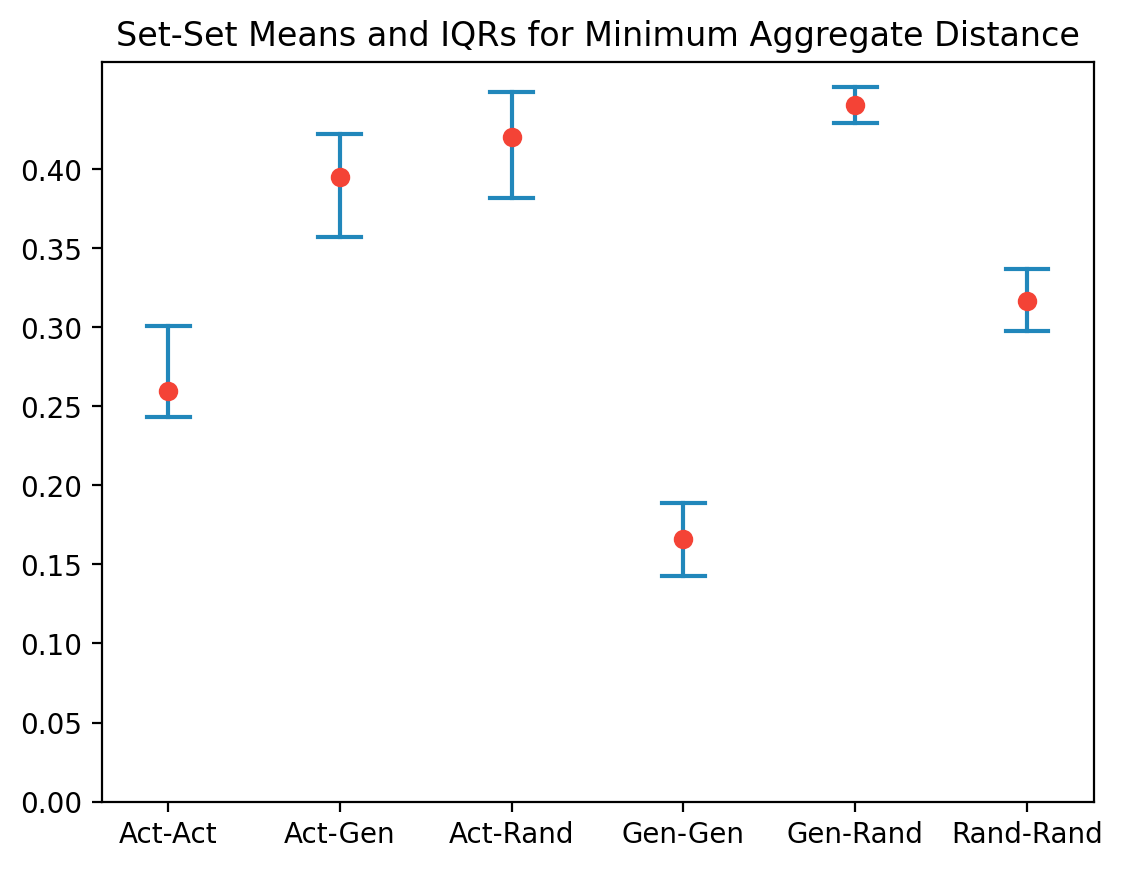

In [56]:
import matplotlib.pyplot as plt
import statistics
from math import sqrt
import scipy.stats as st
import numpy as np

def plot_confidence_interval(x, values, color='#2187bb', horizontal_line_width=0.25):
    mean = np.mean(values)
    p25 = np.percentile(values, 25)
    p75 = np.percentile(values, 75)
    stdev = np.std(values)
    confidence_interval = st.t.interval(alpha = 0.90, df=len(values)-1, loc=mean, scale=stdev)

    left = x - horizontal_line_width / 2
    top = p25 #max(confidence_interval)
    right = x + horizontal_line_width / 2
    bottom = p75 #min(confidence_interval)
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='#f44336')

    return mean, confidence_interval

plt.xticks([1, 2, 3, 4, 5, 6], ['Act-Act', 'Act-Gen', 'Act-Rand', 'Gen-Gen', 'Gen-Rand', 'Rand-Rand'])
plt.title('Set-Set Means and IQRs for Minimum Aggregate Distance')
plot_confidence_interval(1, list(orig_orig_mins.values()))
plot_confidence_interval(2, list(orig_bigr_mins.values()))
plot_confidence_interval(3, list(orig_rand_mins.values()))
plot_confidence_interval(4, list(bigr_bigr_mins.values()))
plot_confidence_interval(5, list(bigr_rand_mins.values()))
plot_confidence_interval(6, list(rand_rand_mins.values()))
plt.yticks([0, 0.05, .1, .15, .2, .25, .3, .35, .4])
plt.show()

In [27]:
# Share of scores such that Ma,Generated < Ma,Random
i = 0
for score in orig_orig_mins.keys():
    if orig_bigr_mins[score] < orig_rand_mins[score]:
        i += 1
print(i/512)

0.990234375


In [28]:
# Average minimum distances
def avg_dict(dict):
    return sum(dict.values()) / len(dict)
print(avg_dict(orig_orig_mins) - avg_dict(orig_bigr_mins))
print(avg_dict(orig_orig_mins) - avg_dict(orig_rand_mins))
print(avg_dict(orig_rand_mins) - avg_dict(orig_bigr_mins))

-0.09207772325464617
-0.16337885580852382
0.07130113255387766


In [ ]:
import Levenshtein
Levenshtein.distance("FGAABBCC", "BGEBFGE")

In [ ]:
# Sense check embedded measure comparisons
import pickle 
import numpy as np
model = FastText.load('fasttext')
encoder_model = model.wv
def embed_measures(partitioned_measures, encoder_model):
    embedded_measures = {}
    for score in partitioned_measures:
        tmp_embedded_measure_set = []
        for measure in partitioned_measures[score]:
            measure_vec = encoder_model[measure.replace("|"," ")]
            tmp_embedded_measure_set.append(measure_vec)
        embedded_measures[score] = tmp_embedded_measure_set[0:8]
    return embedded_measures
abandon1, slangpolska_scores_partitioned_measures, abandon2 = partition_measures_wrapper(slangpolska_scores, "orig")
print(slangpolska_scores_partitioned_measures['3679c385a618c89f00d159f418022b39.xml'])
slangpolska_scores_embedded_measures = embed_measures(slangpolska_scores_partitioned_measures, encoder_model)

# First should be 0, second two should match
tmp_measure_from_i_to_j_mins = []
measure_i = slangpolska_scores_embedded_measures['Östgötasverpen_83557c.xml'][0]
measure_j = slangpolska_scores_embedded_measures['Östgötasverpen_83557c.xml'][0]
cos_sim = dot(measure_i, measure_j)/(norm(measure_i)*norm(measure_j))
angular_dis = np.arccos(cos_sim) / np.pi
print(angular_dis)

measure_i = slangpolska_scores_embedded_measures['Östgötasverpen_83557c.xml'][0]
measure_j = slangpolska_scores_embedded_measures['Östgötasverpen_83557c.xml'][1]
cos_sim = dot(measure_i, measure_j)/(norm(measure_i)*norm(measure_j))
angular_dis = np.arccos(cos_sim) / np.pi
print(angular_dis)
measure_i = slangpolska_scores_embedded_measures['Östgötasverpen_83557c.xml'][1]
measure_j = slangpolska_scores_embedded_measures['Östgötasverpen_83557c.xml'][0]
cos_sim = dot(measure_i, measure_j)/(norm(measure_i)*norm(measure_j))
angular_dis = np.arccos(cos_sim) / np.pi
print(angular_dis)



In [59]:
generated_from_random_partitioned_measures = partition_measures_wrapper(generated_from_random, "rand")
generated_from_bigrams_partitioned_measures = partition_measures_wrapper(generated_from_bigrams, "bigr")
abandon1, slangpolska_scores_partitioned_measures, abandon2 = partition_measures_wrapper(slangpolska_scores, "orig")

model = FastText.load('fasttext')
encoder_model = model.wv

def embed_measures(partitioned_measures, encoder_model):
    embedded_measures = {}
    for score in partitioned_measures:
        tmp_embedded_measure_set = []
        for measure in partitioned_measures[score]:
            measure_vec = encoder_model[measure.replace("|"," ")]
            tmp_embedded_measure_set.append(measure_vec)
        embedded_measures[score] = tmp_embedded_measure_set #[0:8]
    return embedded_measures

slangpolska_scores_embedded_measures = embed_measures(slangpolska_scores_partitioned_measures, encoder_model)
generated_from_random_embedded_measures = embed_measures(generated_from_random_partitioned_measures, encoder_model)
generated_from_bigrams_embedded_measures = embed_measures(generated_from_bigrams_partitioned_measures, encoder_model)

def embed_notes(partitioned_measures, encoder_model):
    embedded_notes = {}
    for score in partitioned_measures:
        tmp_embedded_note_set = []
        for measure in partitioned_measures[score]:
            notes = measure.split("|")
            for note in notes:
                note_vec = encoder_model[note]
                tmp_embedded_note_set.append(note_vec)
        embedded_notes[score] = tmp_embedded_note_set
    return embedded_notes
            
slangpolska_scores_embedded_notes = embed_notes(slangpolska_scores_partitioned_measures, encoder_model)
generated_from_random_embedded_notes = embed_notes(generated_from_random_partitioned_measures, encoder_model)
generated_from_bigrams_embedded_notes = embed_notes(generated_from_bigrams_partitioned_measures, encoder_model)


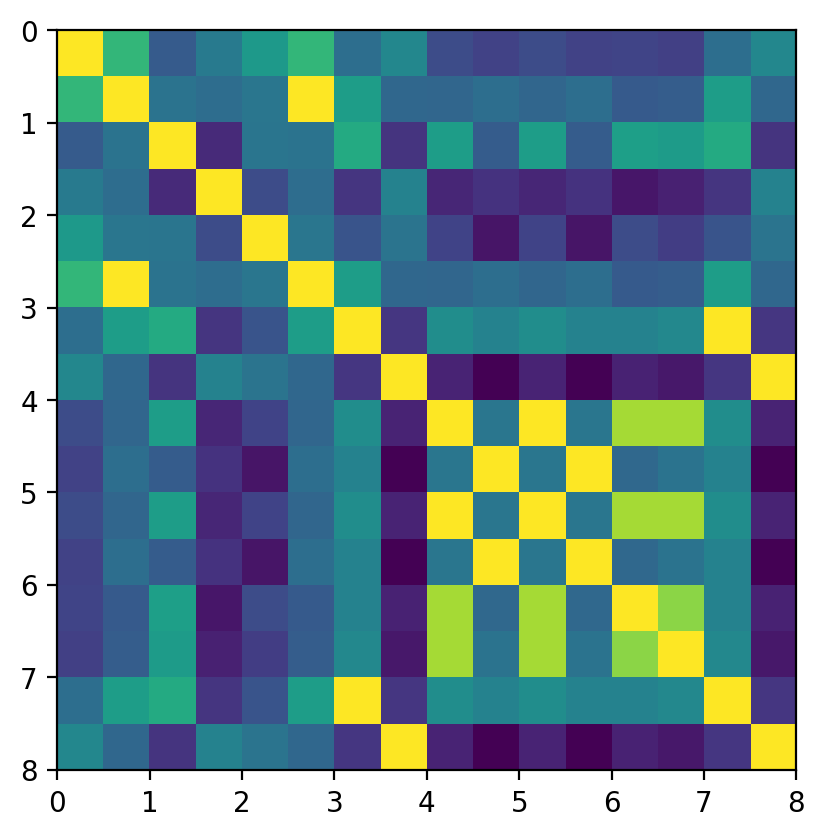

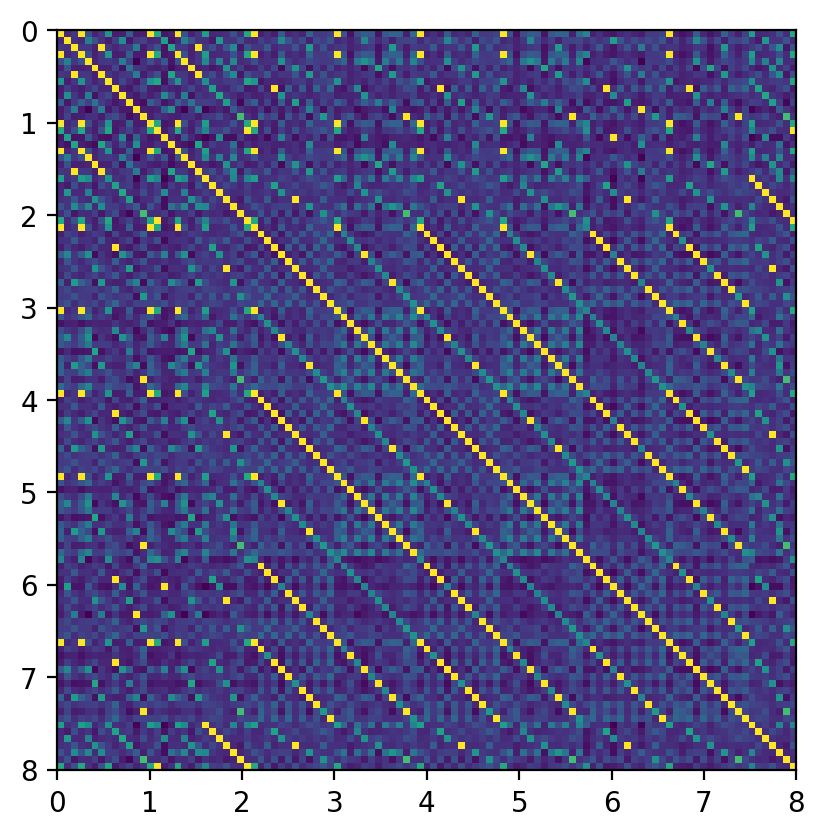

In [66]:
import matplotlib.pyplot as plt
import numpy as np

def plot_self_sim_mat(score_name, score_set):
    length = len(score_set[score_name])
    self_sim_mat = np.zeros((length, length))
    i = 0
    for subblock_i in score_set[score_name]:
        j = 0
        for subblock_j in score_set[score_name]:
            cos_sim = dot(subblock_i, subblock_j)/(norm(subblock_i)*norm(subblock_j))
            if cos_sim > 1:
                cos_sim = 1
            angular_dis = np.arccos(cos_sim) / np.pi
            self_sim_mat[i][j] = 1 - angular_dis
            j += 1
        i += 1
    self_sim_mat
    plt.imshow(self_sim_mat, cmap='viridis', interpolation='nearest', extent=[0,8,8,0])
    
    plt.show()

plot_self_sim_mat('Ninas_slängpolska_316123.xml', slangpolska_scores_embedded_measures)
plot_self_sim_mat('Ninas_slängpolska_316123.xml', slangpolska_scores_embedded_notes)

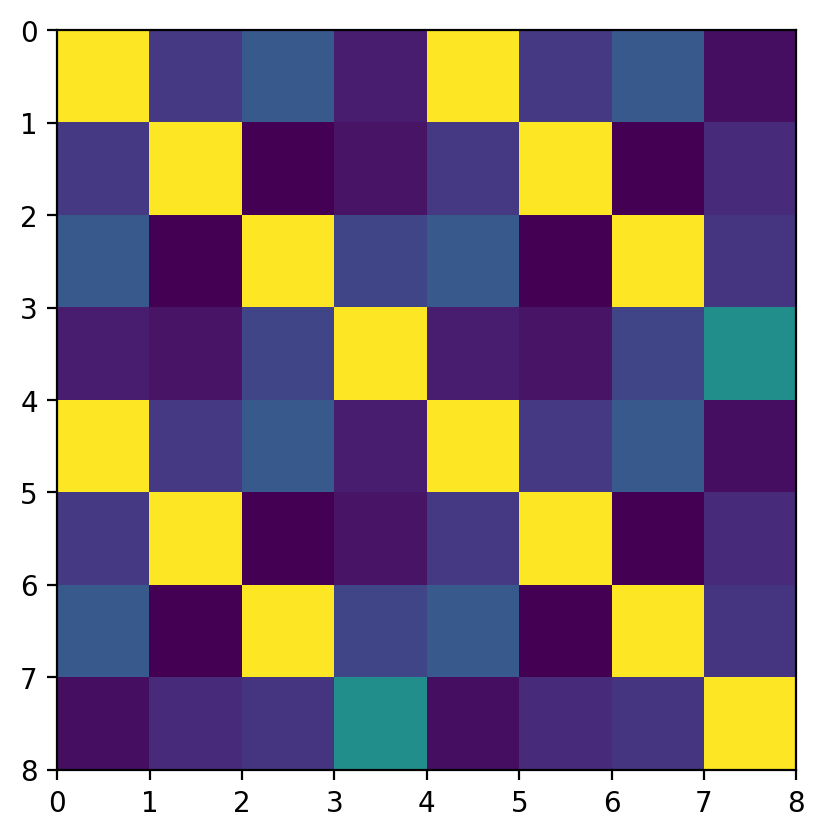

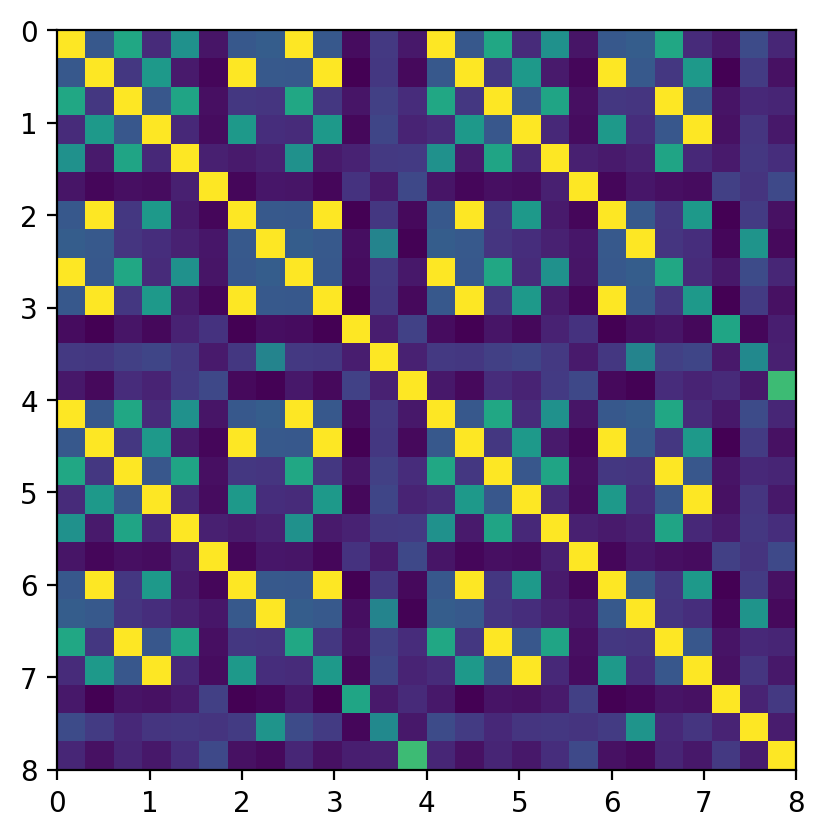

In [75]:
plot_self_sim_mat(429, generated_from_bigrams_embedded_measures)
plot_self_sim_mat(429, generated_from_bigrams_embedded_notes)

In [36]:
# Pull 'good' and 'bad' generated rhythms

def investigate_pairing(all_combined_normalized_distances, against_xml):
    min_dict = {}
    running_overall_min = 100
    running_min_name = ''
    running_min_name_2 = ''
    running_min_name_3 = ''
    running_overall_max = -100
    running_max_name = ''
    running_max_name_2 = ''
    running_max_name_3 = ''
    for i in all_combined_normalized_distances.keys():
        if i.startswith(against_xml):
            min_dict[i] = 100
    for i in all_combined_normalized_distances.keys():
        if i.endswith('.xml'):
            for j in all_combined_normalized_distances[i].keys():
                if j.startswith(against_xml) and all_combined_normalized_distances[i][j] < min_dict[j]:
                        min_dict[j] = all_combined_normalized_distances[i][j]
                if j.startswith(against_xml) and all_combined_normalized_distances[i][j] < running_overall_min:
                        running_overall_min = all_combined_normalized_distances[i][j]
                        running_min_name_3 = running_min_name_2
                        running_min_name_2 = running_min_name
                        running_min_name = (i,j)
                if j.startswith(against_xml) and all_combined_normalized_distances[i][j] > running_overall_max:
                        running_overall_max = all_combined_normalized_distances[i][j]
                        running_max_name_3 = running_max_name_2
                        running_max_name_2 = running_max_name
                        running_max_name = (i,j)
                        
    print(sum(min_dict.values()) / len(min_dict), "average")
    print(max(min_dict.values()), max(min_dict, key=min_dict.get))
    print(min(min_dict.values()), min(min_dict, key=min_dict.get))
    print("mins")
    print((running_min_name, running_min_name_2, running_min_name_3))
    print("maxs")
    print((running_max_name, running_max_name_2, running_max_name_3))
    return min_dict

bigr_orig_mins = investigate_pairing(all_combined_normalized_distances, 'bigr_')

rand_orig_mins = investigate_pairing(all_combined_normalized_distances, 'rand_')

def report_max_min_xml_pairing(all_combined_normalized_distances, min_list, against_xml):
    min_key_to_comp = min(min_list, key = min_list.get)
    max_key_to_comp = max(min_list, key = min_list.get)
    min_value = min_list[min_key_to_comp]
    max_value = min_list[max_key_to_comp]
    for i in all_combined_normalized_distances.keys():
        if i.endswith('.xml'):
            if all_combined_normalized_distances[i][min_key_to_comp] == min_value:
                xml_min_producer = i
            if all_combined_normalized_distances[i][max_key_to_comp] == max_value:
                xml_max_producer = i
    print(min_key_to_comp, xml_min_producer, min_value)

report_max_min_xml_pairing(all_combined_normalized_distances, bigr_orig_mins, 'bigr_')

0.24178132298733518 average
0.3059999332613128 bigr_429
0.19307060697753625 bigr_116
mins
(('_Polonäs_sexdregasamlingen_del_2_nr_77_9fd8bd.xml', 'bigr_116'), ('Pollonesse_183208_7b42e6.xml', 'bigr_193'), ('Pollonesse_183208_7b42e6.xml', 'bigr_37'))
maxs
(('Polonäs_i_Bb_efter_Johan_Eric_Blomgren_331a4e.xml', 'bigr_248'), ('Polonäs_i_Bb_efter_Johan_Eric_Blomgren_331a4e.xml', 'bigr_172'), ('Polonäs_i_Bb_efter_Johan_Eric_Blomgren_331a4e.xml', 'bigr_130'))
0.3824664510076524 average
0.48125701054613096 rand_198
0.2915566393308303 rand_310
mins
(('Ninas_slängpolska_316123.xml', 'rand_310'), ('Ninas_slängpolska_316123.xml', 'rand_304'), ('Ninas_slängpolska_316123.xml', 'rand_199'))
maxs
(('Polonäs_i_Bb_efter_Johan_Eric_Blomgren_331a4e.xml', 'rand_272'), ('Polonäs_i_Bb_efter_Johan_Eric_Blomgren_331a4e.xml', 'rand_119'), ('Groddamors_polska__aef958.xml', 'rand_119'))
bigr_116 _Polonäs_sexdregasamlingen_del_2_nr_77_9fd8bd.xml 0.19307060697753625


In [51]:
import statistics

def pull_low_high_medians(all_combined_normalized_distances, against_xml):
    median_dict = {}
    for j in all_combined_normalized_distances.keys():
        if j.startswith(against_xml):
            tmp = []
            for i in all_combined_normalized_distances.keys():
                if i.endswith('.xml'):
                    tmp.append(all_combined_normalized_distances[i][j])
            median_dict[j] = statistics.median(tmp)
    return median_dict

bigr_orig_medians = pull_low_high_medians(all_combined_normalized_distances, 'bigr_')
sorted(bigr_orig_medians.items(), key=lambda x:x[1])

[('bigr_276', 0.4174906071399735),
 ('bigr_350', 0.41983575933996786),
 ('bigr_339', 0.4221555870628521),
 ('bigr_473', 0.42364625739370243),
 ('bigr_32', 0.4252397243329973),
 ('bigr_145', 0.42566164875850443),
 ('bigr_16', 0.4279667075034425),
 ('bigr_380', 0.4287010091360817),
 ('bigr_124', 0.4290985990662699),
 ('bigr_410', 0.4295023711339734),
 ('bigr_240', 0.4296221734655203),
 ('bigr_288', 0.4301019771037787),
 ('bigr_73', 0.4306312814465778),
 ('bigr_47', 0.43089557267029327),
 ('bigr_176', 0.4327678325323159),
 ('bigr_126', 0.4336311959754582),
 ('bigr_389', 0.43485856506438436),
 ('bigr_188', 0.4361325036719603),
 ('bigr_331', 0.43668097134907424),
 ('bigr_36', 0.4366872875298011),
 ('bigr_18', 0.43696111681625577),
 ('bigr_120', 0.43698765414218366),
 ('bigr_364', 0.43771848034119354),
 ('bigr_357', 0.4377928291042011),
 ('bigr_449', 0.43874233146054187),
 ('bigr_8', 0.44106954932482373),
 ('bigr_460', 0.44107006450294994),
 ('bigr_104', 0.4411545504857025),
 ('bigr_390', 0.

In [55]:
# median perspective
# closest
#generated_from_bigrams[350].show()
#generated_from_bigrams[276].show()
#generated_from_bigrams[339].show()

#furthest
#generated_from_bigrams[452].show()
#generated_from_bigrams[429].show()
#generated_from_bigrams[362].show()

SubConverterFileIOException: No png file for C:\Users\HP\AppData\Local\Temp\music21\tmpzoalpxk4.png (such as C:\Users\HP\AppData\Local\Temp\music21\tmpzoalpxk4-1.png) was found.  The conversion to png failed

In [ ]:
# min perspective
# closest to our original corpus
#generated_from_bigrams[100].show()
#slangpolska_scores['_Polonäs_ur_Andreas_Dahlgrens_notbok_nr_68_515d38.xml'].show()
#generated_from_bigrams[267].show()
#slangpolska_scores['_Edwards_glada_8b403a.xml'].show()
#generated_from_bigrams[151].show()
#slangpolska_scores['_Polska_ur_Trästadssamlingen_f2c069.xml'].show()

#generated_from_bigrams[173].show()


[('B', 4278), ('F#', 3994), ('D', 2568), ('E', 2363), ('G', 2301), ('C#', 1940), ('A', 1530), ('C', 822), ('F', 50)]
[('D', 9314), ('A', 8988), ('G', 8138), ('E', 7569), ('C', 5315), ('B', 5182), ('F#', 4262), ('F', 4078), ('C#', 2980), ('A#', 2365), ('D#', 839), ('G#', 815), ('rest', 59)]


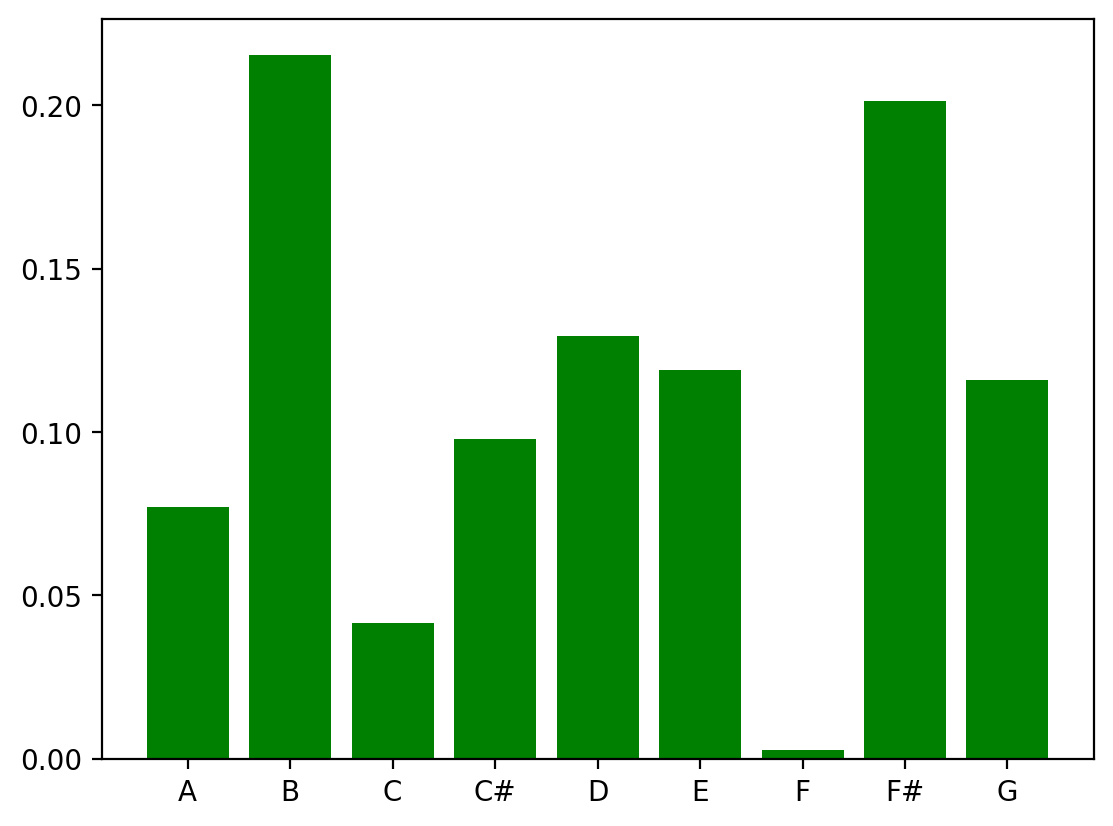

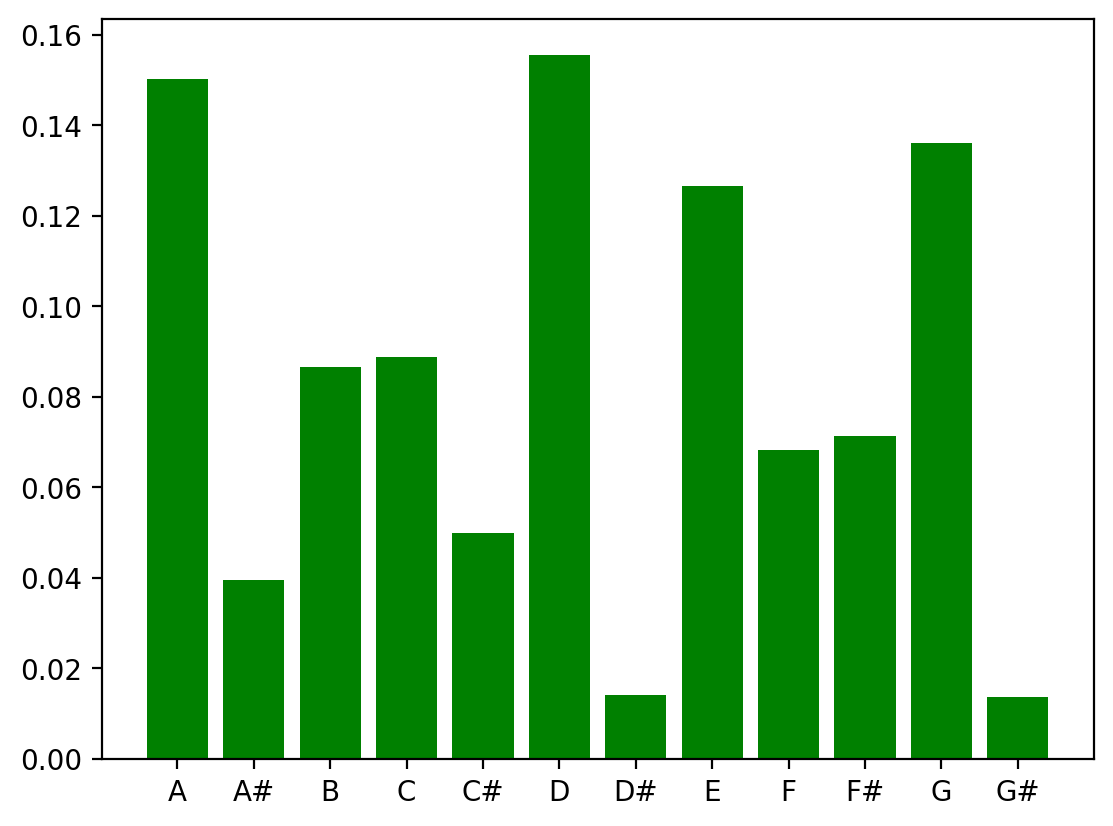

In [29]:
# Tonal character
def pitch_distribution(score_holder):
    all_beats = []
    for score in score_holder:
        for note in score.recurse().notesAndRests:
            try:
                tmp = ''
                pitch = note.name
                if pitch == 'C#' or pitch == 'D-':
                    tmp = 'C#'
                if pitch == 'D#' or pitch == 'E-':
                    tmp = 'D#'
                if pitch == 'F' or pitch == 'E#':
                    tmp = "F"
                if pitch == 'G#' or pitch == 'A-':
                    tmp = "G#"
                if pitch == 'A#' or pitch == 'B-':
                    tmp = "A#"
                if pitch == 'B':
                    tmp = "B"
                if tmp != '':
                    all_beats.append(tmp)
                else:
                    all_beats.append(note.name)
            except:
                pass
    note_pitches = collections.Counter(all_beats).most_common(100)
    print(note_pitches) 
    dist_dict = {}
    for pitch in note_pitches:
        if pitch[0] != 'rest':
            dist_dict[pitch[0]] = pitch[1]

    values = list(dist_dict.values())

    myKeys = list(dist_dict.keys())
    myKeys.sort()

    dist_dict = {i: dist_dict[i]/sum(values) for i in myKeys}
    return dist_dict

slangpolska_score_set = []
for score_name in slangpolska_scores:
    slangpolska_score_set.append(slangpolska_scores[score_name])
dist_dict_bigr = pitch_distribution(generated_from_bigrams)
dist_dict_orig = pitch_distribution(slangpolska_score_set)
# Quick look at onsets

import matplotlib.pyplot as plt
plt.bar(list(dist_dict_bigr.keys()), dist_dict_bigr.values(), color='g')
plt.show()
plt.bar(list(dist_dict_orig.keys()), dist_dict_orig.values(), color='g')
plt.show()
#plt.plot(onset_distribution['atomic_moment'], onset_distribution['frequency'], color='red', marker='o')
#plt.title('Onset Distribution', fontsize=14)
#plt.xlabel('Measure (tick indicates first beat)', fontsize=14)
#plt.xticks([1, 4, 7, 10], ['1','2','3','4'])
#plt.ylabel('Frequency', fontsize=14)
#plt.grid(True)
#plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_7552\3692920740.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df.pivot("pitch", "Set", "prop").plot(kind='bar').legend(loc='upper right')


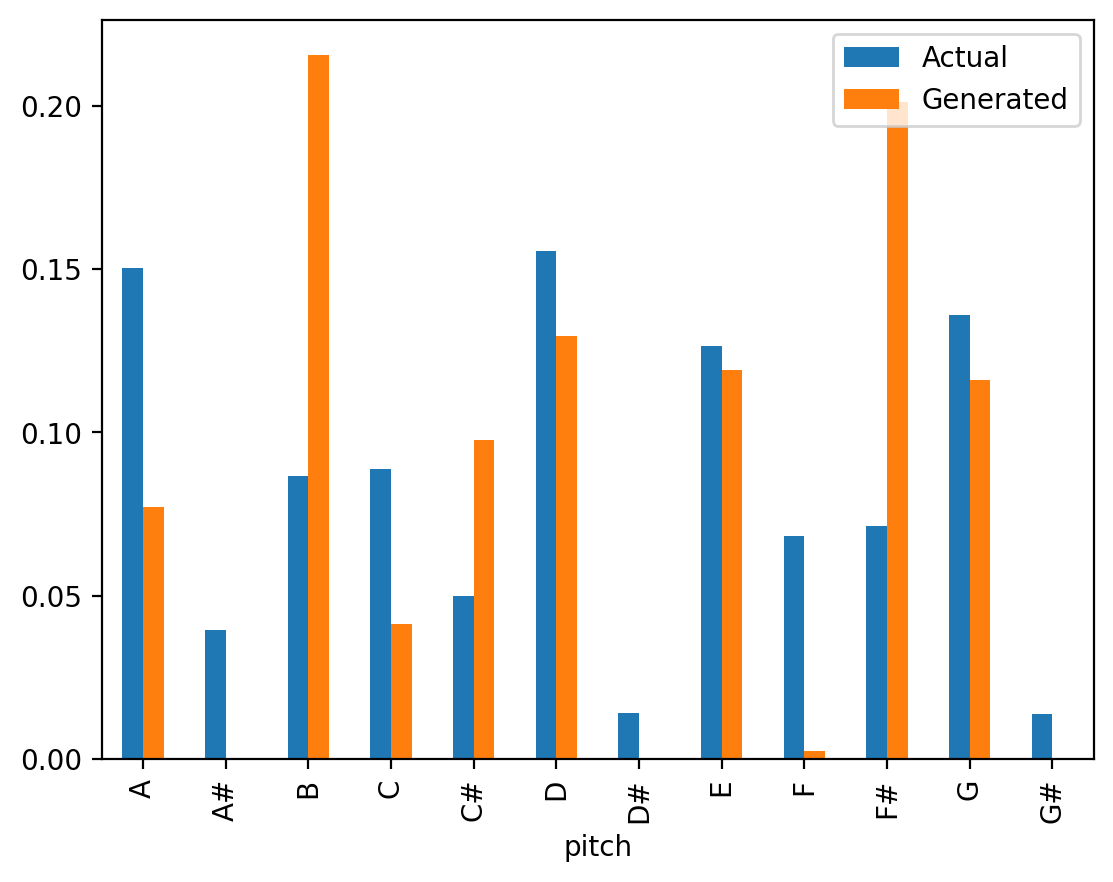

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

dist_pd_bigr = pd.DataFrame.from_dict(dist_dict_bigr, orient='index')
dist_pd_bigr['Set'] = "Generated"
dist_pd_orig = pd.DataFrame.from_dict(dist_dict_orig, orient='index')
dist_pd_orig['Set'] = "Actual"
df = pd.concat([dist_pd_orig, dist_pd_bigr])
df['pitch'] = df.index
df = df.rename(columns={0:"prop"})
df.pivot("pitch", "Set", "prop").plot(kind='bar').legend(loc='upper right')

plt.show()

In [ ]:
## OUTDATED - NO LONGER DECOMPOSED DISTANCES
# Manual orig-orig, orig-bigr, orig-rand... initial pitch distances graph seems off
# Update - it's not off. It's just less precise than our rhythm bigrams. 

with open('levenshtein_costs/insert_costs.pkl', 'rb') as f:
    insert_costs = pickle.load(f)
with open('levenshtein_costs/delete_costs.pkl', 'rb') as f:
    delete_costs = pickle.load(f)
with open('levenshtein_costs/substitute_costs.pkl', 'rb') as f:
    substitute_costs = pickle.load(f)

min_oo = []
min_ob = []
min_or = []

for score_i in tqdm.tqdm(slangpolska_scores.keys()):

    min_normal_Lev_oo = 100
    min_normal_Lev_ob = 100
    min_normal_Lev_or = 100
    min_weighted_Lev_oo = 100
    min_weighted_Lev_ob = 100
    min_weighted_Lev_or = 100

    str1 = pitch_sequence(slangpolska_scores[score_i])
    for score_j in list(slangpolska_scores):
        str2 = pitch_sequence(slangpolska_scores[score_j])
        orig_orig_tmp = Levenshtein.distance(str1, str2)
        orig_orig_tmp2 = levenshtein(str1, len(str1), str2, len(str2), insert_costs, delete_costs, substitute_costs)
        if (orig_orig_tmp < min_normal_Lev_oo) and (score_i != score_j):
            min_normal_Lev_oo = orig_orig_tmp
            min_normal_Lev_oo_score = score_j
        if (orig_orig_tmp2 < min_weighted_Lev_oo) and (score_i != score_j):
            min_weighted_Lev_oo = orig_orig_tmp2
            min_weighted_Lev_oo_score = score_j
    l = -1
    for score_k in generated_from_random:
        l += 1
        str3 = pitch_sequence(score_k)
        orig_rand_tmp = Levenshtein.distance(str1, str3)
        orig_rand_tmp2 = levenshtein(str1, len(str1), str3, len(str3), insert_costs, delete_costs, substitute_costs)
        if orig_rand_tmp < min_normal_Lev_or:
            min_normal_Lev_or = orig_rand_tmp
            min_normal_Lev_or_score = str(l)
        if (orig_orig_tmp2 < min_weighted_Lev_or):
            min_weighted_Lev_or = orig_rand_tmp2
            min_weighted_Lev_or_score = str(l)

    n = -1
    for score_m in generated_from_bigrams:
        n += 1
        str4 = pitch_sequence(score_m)
        orig_bigr_tmp = Levenshtein.distance(str1, str4)
        orig_bigr_tmp2 = levenshtein(str1, len(str1), str4, len(str4), insert_costs, delete_costs, substitute_costs)
        if orig_bigr_tmp < min_normal_Lev_ob:
            min_normal_Lev_ob = orig_bigr_tmp
            min_normal_Lev_ob_score = str(n)
        if (orig_bigr_tmp2 < min_weighted_Lev_ob):
            min_weighted_Lev_ob = orig_bigr_tmp2
            min_weighted_Lev_ob_score = str(n)
    #print(score_i + "|| oo normal: " + str(min_normal_Lev_oo) + " from " + min_normal_Lev_oo_score + ", or normal: " + str(min_normal_Lev_or) + " from " + min_normal_Lev_or_score)
    #print(min_normal_Lev_oo, min_normal_Lev_ob, min_normal_Lev_or)
    #print(min_weighted_Lev_oo, min_weighted_Lev_ob, min_weighted_Lev_or)
    min_oo.append(min_weighted_Lev_oo)
    min_ob.append(min_weighted_Lev_ob)
    min_or.append(min_weighted_Lev_or)
    with open('manual_pitch_distances_oo.pkl', 'wb') as f:
        pickle.dump(min_oo, f)
    with open('manual_pitch_distances_ob.pkl', 'wb') as f:
        pickle.dump(min_ob, f)
    with open('manual_pitch_distances_or.pkl', 'wb') as f:
        pickle.dump(min_or, f)

def find_min_by_lefthand_score(set_to_set_distances):
    with open('all_distances/' + set_to_set_distances + '.pkl', 'rb') as f:
        distance_dict = pickle.load(f)
    distance_dict_mins_dict = {}
    for score in distance_dict.keys():
        distance_dict_mins_dict[score] = {}
        tmp_min = 100
        for comp in distance_dict[score].keys():
            if (distance_dict[score][comp] < tmp_min) and (score != comp):
                tmp_min = distance_dict[score][comp]
        distance_dict_mins_dict[score] = tmp_min
    return distance_dict_mins_dict

min_oo_pitch = find_min_by_lefthand_score("orig_to_orig_pitch_distances")
min_or_pitch = find_min_by_lefthand_score("orig_to_rand_pitch_distances")
min_ob_pitch = find_min_by_lefthand_score("orig_to_bigr_pitch_distances")
min_bb_pitch = find_min_by_lefthand_score("bigr_to_bigr_pitch_distances")
min_br_pitch = find_min_by_lefthand_score("bigr_to_rand_pitch_distances")
min_rr_pitch = find_min_by_lefthand_score("rand_to_rand_pitch_distances")

print(pd.Series(min_or_pitch.values()).describe())

def plot_confidence_interval(x, values, color='#2187bb', horizontal_line_width=0.25):
    mean = np.mean(values)
    stdev = np.std(values)
    p25 = np.percentile(values, 25)
    p75 = np.percentile(values,75)
    confidence_interval = st.t.interval(alpha = 0.95, df=len(values)-1, loc=mean, scale=stdev)

    left = x - horizontal_line_width / 2
    top = p75 #max(confidence_interval)
    right = x + horizontal_line_width / 2
    bottom = p25 #min(confidence_interval)
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='#f44336')

    return mean, confidence_interval

print(type(min_oo_pitch.values()))
plt.xticks([1, 2, 3, 4, 5, 6], ['Orig-Orig', 'Orig-Bigr', 'Orig-Rand', 'Bigr-Bigr', 'Bigr-Rand', 'Rand-Rand'])
plt.title('Weighted Levenshtein Pitch Distance Confidence Interval')
plot_confidence_interval(1, list(min_oo_pitch.values()))
plot_confidence_interval(2, list(min_ob_pitch.values()))
plot_confidence_interval(3, list(min_or_pitch.values()))
plot_confidence_interval(4, list(min_bb_pitch.values()))
plot_confidence_interval(5, list(min_br_pitch.values()))
plot_confidence_interval(6, list(min_rr_pitch.values()))
plt.show()


In [ ]:
import Levenshtein
Levenshtein.distance("BGEBFGE", "FGAABBCC")
Levenshtein.editops("BGEBFGE", "FGAABBCC")

In [ ]:
# Chronotonic distance calculation. We actually use a function in helpers.py that produces effectively equivalent results (that one 
# interpolates piecewise functions with larger steps to save memory). 

import music21
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import random

def chronotonic_comparison(stream_base_score_1, stream_base_score_2, subset_start = -1, show_graphs = False):
    final_measure_1 = stream_base_score_1.recurse().notesAndRests[-1].measureNumber
    final_measure_2 = stream_base_score_2.recurse().notesAndRests[-1].measureNumber
    final_measure_for_subset = final_measure_1
    if final_measure_2 < final_measure_for_subset:
        final_measure_for_subset = final_measure_2
    if (final_measure_for_subset < 8) or (final_measure_for_subset < (subset_start + 7)):
        print("ONE OF THE SCORES IS TOO SHORT")
        return "ONE OF THE SCORES IS TOO SHORT"
    if subset_start == -1:
        while True:
            subset_start = random.randint(1, (final_measure_for_subset - 8)+1)
            if subset_start%2 != 0:
                break
    else:
        # subset start passed in
        pass
    chrono1, xvals1, yvals1, xticks1, xlabs1 = chronotonic_builder(stream_base_score_1, subset_start, show_graphs)
    chrono2, xvals2, yvals2, xticks2, xlabs2 = chronotonic_builder(stream_base_score_2, subset_start, show_graphs)
    maxyvals = max(yvals1)
    if maxyvals < max(yvals2):
        maxyvals = max(yvals2)
    linspaced_subsets = pd.DataFrame(list(zip(xvals1, yvals1, xvals2, yvals2)), columns=['score1_xvals', 'score1_yvals', 'score2_xvals', 'score2_yvals'])
    linspaced_subsets['x_diff'] = linspaced_subsets['score1_xvals'] - linspaced_subsets['score2_xvals']
    linspaced_subsets['y_diff'] = abs(linspaced_subsets['score1_yvals'] - linspaced_subsets['score2_yvals'])
    if show_graphs == True:
        fig, ax = plt.subplots()
        bar_plot = ax.bar(chrono1['onsets'], chrono1['heights'], width=chrono1['bin_widths'], align='edge', alpha = .3) # edgecolor='black'
        bar_plot = ax.bar(chrono2['onsets'], chrono2['heights'], width=chrono2['bin_widths'], align='edge', color='red', alpha = .3) # edgecolor='black'
        ax.set_ylabel("Note Length")
        ax.set_xlabel("Measure # (Tick Indicates First Beat of Measure)")
        plt.title("Chronotonic sequence overlap (random 8-bar subset)")
        plt.plot(xvals1, yvals1, 'blue', alpha = 0.9)
        plt.plot(xvals2, yvals2, 'red', alpha = 0.9)
        plt.xticks(xticks1, xlabs1)
        plt.ylim([0,maxyvals+0.25])
        plt.show()
        plt.figure()
        plt.plot(linspaced_subsets['score1_xvals'],linspaced_subsets['y_diff'],color='black')
        maxdiff = max(linspaced_subsets['y_diff'])
        plt.xticks(xticks1, xlabs1)
        plt.ylim([0,maxdiff+0.25])
        plt.ylabel('Difference in Note Length')
        plt.xlabel('Measure # (Tick Indicates First Beat of Measure)')
        x_axis = np.linspace(xticks1[0], xticks1[-1], 10000, endpoint=True)
        plt.fill_between(x_axis, linspaced_subsets['y_diff'], color='black', alpha = .3)
        plt.title("Absolute Difference in Chronotonic Sequence")
        plt.show()
    #print(pd.DataFrame(list(zip(chrono1['onsets'],chrono2['onsets'])),columns=('chrono1_onsets','chrono2_onsets')))
    return np.trapz(linspaced_subsets['y_diff'], linspaced_subsets['score1_xvals'])
    #return linspaced_subsets
    
def chronotonic_builder(stream_base_score, subset_start=1, show_graphs = False):
    onsets = []
    heights = []
    final_measure = stream_base_score.recurse().notesAndRests[-1].measureNumber
    for n_or_r in stream_base_score.recurse().notesAndRests:
        #print(n_or_r, n_or_r.beat + (3 * (n_or_r.measureNumber-1)), n_or_r.duration.quarterLength)
        onsets.append(n_or_r.beat + (3 * (n_or_r.measureNumber-1)))
        if isinstance(n_or_r, (music21.note.Note,music21.chord.Chord)):
            heights.append(n_or_r.duration.quarterLength)
        else:
            heights.append(float(0))
    x = np.asarray(onsets)
    y = np.asarray(heights)
    if show_graphs == True:
        fig, ax = plt.subplots()
        bar_plot = ax.bar(x, y, width=y, align='edge', edgecolor='black') # width=bin_width
        ax.set_ylabel("Note Length")
        ax.set_xlabel("Measure (tick indicates first beat)")
        x_tick_locs = np.arange(1, final_measure*3, 3).tolist()
        x_tick_labels = [str(int(((x-1)/3)+1)) for x in x_tick_locs]
        #print(x_tick_locs, x_tick_labels)
        plt.xticks(x_tick_locs, x_tick_labels)
        plt.title("Full chronotonic sequence")
        plt.show()

    # Now display a random subset
    chronotonic_start = subset_start
    chronotonic_end = chronotonic_start + 8
    filter_arr_start = (x >= (3*(chronotonic_start-1))+1)

    chrono_sequence = pd.DataFrame(list(zip(filter_arr_start.tolist(), x.tolist(), y.tolist())), columns=['filter_start','onsets','heights'])
    chrono_sequence = chrono_sequence[chrono_sequence['onsets'] < ((3*(chronotonic_end-1))+1)]
    first_index = chrono_sequence.index[chrono_sequence['filter_start'] == True].tolist()[0]
    if first_index != 0:
        chrono_sequence = chrono_sequence[first_index-1:]
        #print(first_index, chrono_sequence)
        if int(chrono_sequence['onsets'].tolist()[1]) == int((3*(chronotonic_start-1))+1):
            chrono_sequence = chrono_sequence[1:]
        else:
            chrono_sequence.at[0,'onsets'] = (3*(chronotonic_start-1))+1
    else:
        chrono_sequence = chrono_sequence[first_index:]
    chrono_sequence['bin_widths'] = chrono_sequence.diff(periods=-1)['onsets']*-1
    chrono_sequence.at[chrono_sequence.iloc[-1].name,'bin_widths'] = ((3*(chronotonic_end-1))+1) - chrono_sequence['onsets'].tolist()[-1]
    
    # Pulled out of if statement so they can be passed to comparison graph
    x_tick_locs = np.arange((3*(chronotonic_start-1))+1, (3*(chronotonic_end-1))+2, 3).tolist()
    x_tick_labels = [str(int(((x-1)/3)+1)) for x in x_tick_locs]
    if show_graphs == True:
        fig, ax = plt.subplots()
        bar_plot = ax.bar(chrono_sequence['onsets'], chrono_sequence['heights'], width=chrono_sequence['bin_widths'], align='edge', edgecolor='black', alpha = .5) # width=bin_width
        ax.set_ylabel("Note Length")
        ax.set_xlabel("Measure (tick indicates first beat)")
        #x_tick_locs = np.arange((3*(chronotonic_start-1))+1, (3*(chronotonic_end-1))+2, 3).tolist()
        #x_tick_labels = [str(int(((x-1)/3)+1)) for x in x_tick_locs]
        plt.xticks(x_tick_locs, x_tick_labels)
        plt.title("Chronotonic sequence subset")

    # Add interpolated version, to be used in difference calculations
    onsets_list = chrono_sequence['onsets'].tolist()
    heights_list = chrono_sequence['heights'].tolist()
    x_for_interp = []
    y_for_interp = []
    for i,x in enumerate(onsets_list):
        if i != 0:
            x_for_interp.append(float(onsets_list[i-1]))
            y_for_interp.append(float(heights_list[i-1]))
            x_for_interp.append(float(onsets_list[i]-.000001))
            y_for_interp.append(float(heights_list[i-1]))
    x_for_interp.append(float(onsets_list[-1]))
    y_for_interp.append(float(heights_list[-1]))
    xvals = np.linspace((3*(chronotonic_start-1))+1, (3*(chronotonic_end-1))+1, 10000)
    yinterp = np.interp(xvals, x_for_interp, y_for_interp)
    if show_graphs == True:
        plt.plot(xvals, yinterp, 'blue')
        plt.show()
    return chrono_sequence, xvals, yinterp, x_tick_locs, x_tick_labels

In [ ]:
# EXAMPLE CHRONOTONIC SEQUENCE AND DISTANCES
# Now, a function that passes in a score name to create the above graphs
# chronotonic_builder(slangpolska_scores['_Polonäs_Mollo_sexdregasamlingen_del_3_nr_48_628b4c.xml'], show_graphs=True)
chronotonic_comparison(slangpolska_scores['Pollonesse_183254_460e7c.xml'], slangpolska_scores['_Polonäs_Mollo_sexdregasamlingen_del_3_nr_48_628b4c.xml'], subset_start = 1, show_graphs=True)

In [ ]:
# Sense checks for distance function
# first must be 0
# second and third might differ without subset_start argument, that's due to randomness in 8 bars selected for comparison.
print(chronotonic_comparison(slangpolska_scores['Pollonesse_183254_460e7c.xml'], slangpolska_scores['Pollonesse_183254_460e7c.xml'],show_graphs=False))
print(chronotonic_comparison(slangpolska_scores['Pollonesse_183254_460e7c.xml'], slangpolska_scores['_Polonäs_Mollo_sexdregasamlingen_del_3_nr_48_628b4c.xml'], subset_start = 1, show_graphs=False))
print(chronotonic_comparison(slangpolska_scores['_Polonäs_Mollo_sexdregasamlingen_del_3_nr_48_628b4c.xml'], slangpolska_scores['Pollonesse_183254_460e7c.xml'], subset_start = 1, show_graphs=False))

In [ ]:
# Example for paper - three bars of Dahl_polska_efter_Ola_Olsson_bf94a6.xml

chrono1, xvals1, yvals1, xticks1, xlabs1 = chronotonic_builder(slangpolska_scores['Dahl_polska_efter_Ola_Olsson_bf94a6.xml'], subset_start = 1, show_graphs=False)
#chrono_sequence
fig, ax = plt.subplots()
xvals_6bars = chrono1['onsets'][chrono1['onsets'] < 16]
yvals_6bars = chrono1['heights'][chrono1['onsets'] < 16]
binw_6bars = chrono1['bin_widths'][chrono1['onsets'] < 16]
xvals_3bars = xvals_6bars.loc[xvals_6bars.loc[lambda x : x >= 10].index.values.tolist()]
yvals_3bars = yvals_6bars.loc[xvals_6bars.loc[lambda x : x >= 10].index.values.tolist()]
binw_3bars = binw_6bars.loc[xvals_6bars.loc[lambda x : x >= 10].index.values.tolist()]

bar_plot = ax.bar(xvals_3bars, yvals_3bars, width=binw_3bars, align='edge', edgecolor='black', alpha = .5) # width=bin_width
ax.set_xlabel("Measure.Beat", fontsize=12)
plt.xticks([10,11,12,13,14,15,16], ['4.1','4.2','4.3','5.1','5.2','5.3','6.1'], fontsize=10)
xvals = np.array(xvals1)
tmp_indices = np.where(np.logical_and(xvals > 10,xvals < 16), True, False)
plt.rcParams['figure.figsize'] = [8,8]
plt.plot(xvals[tmp_indices], yvals1[tmp_indices], 'blue')
ax.set_aspect('equal')
plt.rcParams['figure.figsize'] = [8,8]
ax.get_yaxis().set_visible(False)
plt.show()

chrono2, xvals2, yvals2, xticks2, xlabs2 = chronotonic_builder(slangpolska_scores['_1814_698087.xml'], subset_start = 1, show_graphs=False)

maxyvals = max(yvals1)
if maxyvals < max(yvals2):
    maxyvals = max(yvals2)
linspaced_subsets = pd.DataFrame(list(zip(xvals1, yvals1, xvals2, yvals2)), columns=['score1_xvals', 'score1_yvals', 'score2_xvals', 'score2_yvals'])
linspaced_subsets['x_diff'] = linspaced_subsets['score1_xvals'] - linspaced_subsets['score2_xvals']
linspaced_subsets['y_diff'] = abs(linspaced_subsets['score1_yvals'] - linspaced_subsets['score2_yvals'])

fig, ax = plt.subplots()

xvals2_6bars = chrono2['onsets'][chrono2['onsets'] < 16]
yvals2_6bars = chrono2['heights'][chrono2['onsets'] < 16]
binw2_6bars = chrono2['bin_widths'][chrono2['onsets'] < 16]
xvals2_3bars = xvals2_6bars.loc[xvals2_6bars.loc[lambda x : x >= 10].index.values.tolist()]
yvals2_3bars = yvals2_6bars.loc[xvals2_6bars.loc[lambda x : x >= 10].index.values.tolist()]
binw2_3bars = binw2_6bars.loc[xvals2_6bars.loc[lambda x : x >= 10].index.values.tolist()]

bar_plot = ax.bar(xvals_3bars, yvals_3bars, width=binw_3bars, align='edge', edgecolor='black', alpha = .5) # edgecolor='black'
bar_plot = ax.bar(xvals2_3bars, yvals2_3bars, width=binw2_3bars, align='edge', color='red', edgecolor='black', alpha = .5) # edgecolor='black'
#ax.set_ylabel("Note Length")
#ax.set_xlabel("Measure # (Tick Indicates First Beat of Measure)")
#plt.title("Chronotonic sequence overlap (random 8-bar subset)")
plt.plot(xvals[tmp_indices], yvals1[tmp_indices], alpha = 1)
plt.plot(xvals[tmp_indices], yvals2[tmp_indices], 'red', alpha = 1)
plt.xticks([10,11,12,13,14,15,16], ['4.1','4.2','4.3','5.1','5.2','5.3','6.1'])
plt.ylim([0,1.25])
ax.set_aspect('equal')
plt.rcParams['figure.figsize'] = [8,8]
ax.get_yaxis().set_visible(False)
plt.xlabel("Measure.Beat", fontsize=12)
#plt.show()

fig, ax = plt.subplots()
tmp_indices = np.where(np.logical_and(linspaced_subsets['score1_xvals'] > 10,linspaced_subsets['score1_xvals'] < 16), True, False)
linsubs_xvals_3bars = linspaced_subsets['score1_xvals'].loc[tmp_indices]
linsubs_yvals_3bars = linspaced_subsets['y_diff'].loc[tmp_indices]

plt.plot(linsubs_xvals_3bars,linsubs_yvals_3bars,color='black')
plt.xticks([10,11,12,13,14,15,16], ['4.1','4.2','4.3','5.1','5.2','5.3','6.1'])
plt.ylim([0,1])
plt.fill_between(linsubs_xvals_3bars, linsubs_yvals_3bars, color='black', alpha = .3)
ax.set_aspect('equal')
plt.rcParams['figure.figsize'] = [4,4]
ax.get_yaxis().set_visible(False)
plt.xlabel("Measure.Beat", fontsize=12)
plt.show(5)

np.trapz(linsubs_yvals_3bars, linsubs_xvals_3bars)


In [ ]:
# recover and modify graphs in original chronotonic distance func for use in paper
# work is done here - rest is for paper

# Chronotonic distance calculation. We actually use a function further down in the script that produces effectively equivalent results (later function 
# interpolates piecewise functions with larger steps to save memory). 

import music21
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import random

def chronotonic_comparison_paper(stream_base_score_1, stream_base_score_2, subset_start = -1, show_graphs = False):
    final_measure_1 = stream_base_score_1.recurse().notesAndRests[-1].measureNumber
    final_measure_2 = stream_base_score_2.recurse().notesAndRests[-1].measureNumber
    final_measure_for_subset = final_measure_1
    if final_measure_2 < final_measure_for_subset:
        final_measure_for_subset = final_measure_2
    if (final_measure_for_subset < 8) or (final_measure_for_subset < (subset_start + 7)):
        print("ONE OF THE SCORES IS TOO SHORT")
        return "ONE OF THE SCORES IS TOO SHORT"
    if subset_start == -1:
        while True:
            subset_start = random.randint(1, (final_measure_for_subset - 8)+1)
            if subset_start%2 != 0:
                break
    else:
        # subset start passed in
        pass
    chrono1, xvals1, yvals1, xticks1, xlabs1 = chronotonic_builder_paper(stream_base_score_1, subset_start, show_graphs)
    chrono2, xvals2, yvals2, xticks2, xlabs2 = chronotonic_builder_paper(stream_base_score_2, subset_start, show_graphs)
    maxyvals = max(yvals1)
    if maxyvals < max(yvals2):
        maxyvals = max(yvals2)

    fig, ax = plt.subplots()
    bar_plot = ax.bar(chrono1['onsets'], chrono1['heights'], width=chrono1['bin_widths'], align='edge', alpha = .3) # edgecolor='black'
    bar_plot = ax.bar(chrono2['onsets'], chrono2['heights'], width=chrono2['bin_widths'], align='edge', color='red', alpha = .3) # edgecolor='black'
    ax.set_ylabel("Note Length")
    ax.set_xlabel("Measure # (Tick Indicates First Beat of Measure)", fontsize=12)
    plt.title("Chronotonic sequence overlap (random 8-bar subset)")
    plt.plot(xvals1, yvals1, 'blue', alpha = 0.9)
    plt.plot(xvals2, yvals2, 'red', alpha = 0.9)
    plt.xticks(xticks1, xlabs1)
    ax.set_aspect('equal')
    plt.rcParams['figure.figsize'] = [8,8]
    ax.get_yaxis().set_visible(False)
    if maxyvals < 1:
        plt.ylim([0,maxyvals+2])
    plt.show()
    
def chronotonic_builder_paper(stream_base_score, subset_start=1, show_graphs = False):
    onsets = []
    heights = []
    final_measure = stream_base_score.recurse().notesAndRests[-1].measureNumber
    for n_or_r in stream_base_score.recurse().notesAndRests:
        #print(n_or_r, n_or_r.beat + (3 * (n_or_r.measureNumber-1)), n_or_r.duration.quarterLength)
        onsets.append(n_or_r.beat + (3 * (n_or_r.measureNumber-1)))
        if isinstance(n_or_r, (music21.note.Note,music21.chord.Chord)):
            heights.append(n_or_r.duration.quarterLength)
        else:
            heights.append(float(0))
    x = np.asarray(onsets)
    y = np.asarray(heights)
    if show_graphs == True:
        fig, ax = plt.subplots()
        bar_plot = ax.bar(x, y, width=y, align='edge', edgecolor='black') # width=bin_width
        ax.set_ylabel("Note Length")
        ax.set_xlabel("Measure (tick indicates first beat)")
        x_tick_locs = np.arange(1, final_measure*3, 3).tolist()
        x_tick_labels = [str(int(((x-1)/3)+1)) for x in x_tick_locs]
        #print(x_tick_locs, x_tick_labels)
        plt.xticks(x_tick_locs, x_tick_labels)
        plt.title("Full chronotonic sequence")
        #plt.show()

    # Now display a random subset
    chronotonic_start = subset_start
    chronotonic_end = chronotonic_start + 8
    filter_arr_start = (x >= (3*(chronotonic_start-1))+1)

    chrono_sequence = pd.DataFrame(list(zip(filter_arr_start.tolist(), x.tolist(), y.tolist())), columns=['filter_start','onsets','heights'])
    chrono_sequence = chrono_sequence[chrono_sequence['onsets'] < ((3*(chronotonic_end-1))+1)]
    first_index = chrono_sequence.index[chrono_sequence['filter_start'] == True].tolist()[0]
    if first_index != 0:
        chrono_sequence = chrono_sequence[first_index-1:]
        #print(first_index, chrono_sequence)
        if int(chrono_sequence['onsets'].tolist()[1]) == int((3*(chronotonic_start-1))+1):
            chrono_sequence = chrono_sequence[1:]
        else:
            chrono_sequence.at[0,'onsets'] = (3*(chronotonic_start-1))+1
    else:
        chrono_sequence = chrono_sequence[first_index:]
    chrono_sequence['bin_widths'] = chrono_sequence.diff(periods=-1)['onsets']*-1
    chrono_sequence.at[chrono_sequence.iloc[-1].name,'bin_widths'] = ((3*(chronotonic_end-1))+1) - chrono_sequence['onsets'].tolist()[-1]
    
    # Pulled out of if statement so they can be passed to comparison graph
    x_tick_locs = np.arange((3*(chronotonic_start-1))+1, (3*(chronotonic_end-1))+2, 3).tolist()
    x_tick_labels = [str(int(((x-1)/3)+1)) for x in x_tick_locs]
    if show_graphs == True:
        fig, ax = plt.subplots()
        bar_plot = ax.bar(chrono_sequence['onsets'], chrono_sequence['heights'], width=chrono_sequence['bin_widths'], align='edge', edgecolor='black', alpha = .5) # width=bin_width
        ax.set_ylabel("Note Length")
        ax.set_xlabel("Measure (tick indicates first beat)")
        #x_tick_locs = np.arange((3*(chronotonic_start-1))+1, (3*(chronotonic_end-1))+2, 3).tolist()
        #x_tick_labels = [str(int(((x-1)/3)+1)) for x in x_tick_locs]
        plt.xticks(x_tick_locs, x_tick_labels)
        plt.title("Chronotonic sequence subset")

    # Add interpolated version, to be used in difference calculations
    onsets_list = chrono_sequence['onsets'].tolist()
    heights_list = chrono_sequence['heights'].tolist()
    x_for_interp = []
    y_for_interp = []
    for i,x in enumerate(onsets_list):
        if i != 0:
            x_for_interp.append(float(onsets_list[i-1]))
            y_for_interp.append(float(heights_list[i-1]))
            x_for_interp.append(float(onsets_list[i]-.000001))
            y_for_interp.append(float(heights_list[i-1]))
    x_for_interp.append(float(onsets_list[-1]))
    y_for_interp.append(float(heights_list[-1]))
    xvals = np.linspace((3*(chronotonic_start-1))+1, (3*(chronotonic_end-1))+1, 10000)
    yinterp = np.interp(xvals, x_for_interp, y_for_interp)
    if show_graphs == True:
        plt.plot(xvals, yinterp, 'blue')
        #plt.show()
    return chrono_sequence, xvals, yinterp, x_tick_locs, x_tick_labels

#Example bad generated score
#chronotonic_comparison_paper(slangpolska_scores['Ninas_slängpolska_316123.xml'], generated_from_bigrams[35], subset_start = 1, show_graphs=True)
#Example good generated score
#chronotonic_comparison_paper(slangpolska_scores['Polonäs_9ddddb.xml'], generated_from_bigrams[243], subset_start = 1, show_graphs=True)

# To display bad/good examples (first two bad second two good)
#slangpolska_scores['Ninas_slängpolska_316123.xml'].show()
#generated_from_bigrams[35].show()
#slangpolska_scores['Polonäs_9ddddb.xml'].show()
#generated_from_bigrams[243].show()
